In [1]:
#Bring in elevation data
import pandas as pd
import json 
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pystac_client import Client
import planetary_computer
import xarray
import rioxarray
from pyproj import Transformer
import h5py
from mpl_toolkits.basemap import Basemap
import math
from tqdm import tqdm
import geopandas
import richdem as rd
import elevation
import hdfdict
import pickle
import random


import io
from datetime import date, timedelta

import xarray as xr
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

# Not used directly, but used via xarray
import cfgrib
import netCDF4
import tempfile
import os
from platform import python_version


from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

print(pd.__version__) # should be 1.3.0
print(python_version()) #should be 3.8.2

1.3.0
3.8.2


In [2]:
#added Long,Lat to get polygon points
def GeoStat_func(i, Geospatial_df, regions, elev_L, slope_L, aspect_L, Long, Lat, tile):

    # convert coordinate to raster value
    lon = Geospatial_df.iloc[i][Long]
    lat = Geospatial_df.iloc[i][Lat]

    
    
    #connect point location to geotile
    tileid = 'Copernicus_DSM_COG_30_N' + str(math.floor(lat)) + '_00_W'+str(math.ceil(abs(lon))) +'_00_DEM'
    
    indexid = regions.loc[tileid]['sliceID']
    

   #Assing region
    signed_asset = planetary_computer.sign(tiles[indexid].assets["data"])
    #get elevation data in xarray object
    elevation = rioxarray.open_rasterio(signed_asset.href)

    #create copies to extract other geopysical information
    #Create Duplicate DF's
    slope = elevation.copy()
    aspect = elevation.copy()
        
    
    #transform projection
    transformer = Transformer.from_crs("EPSG:4326", elevation.rio.crs, always_xy=True)
    xx, yy = transformer.transform(lon, lat)
    
    #extract elevation values into numpy array
    tilearray = np.around(elevation.values[0]).astype(int)

    #set tile geo to get slope and set at rdarray
    geo = (math.floor(float(lon)), 90, 0.0, math.ceil(float(lat)), 0.0, -90)
    tilearray = rd.rdarray(tilearray, no_data = -9999)
    tilearray.projection = 'EPSG:4326'
    tilearray.geotransform = geo

    #get slope, note that slope needs to be fixed, way too high
    #get aspect value
    slope_arr = rd.TerrainAttribute(tilearray, attrib='slope_degrees')
    aspect_arr = rd.TerrainAttribute(tilearray, attrib='aspect')

    #save slope and aspect information 
    slope.values[0] = slope_arr
    aspect.values[0] = aspect_arr

    # get point values from grid
    elev = round(elevation.sel(x=(xx,), y=yy, method="nearest").values[0][0])
    slop = round(slope.sel(x=(xx,), y=yy, method="nearest").values[0][0])
    asp = round(aspect.sel(x=(xx,), y=yy, method="nearest").values[0][0])
    
    
    #add point values to list
    elev_L.append(elev)
    slope_L.append(slop)
    aspect_L.append(asp)

In [3]:
#get mean Geospatial data
def mean_Geo(df, geo):
    BL = 'BL'+geo
    UL = 'UL'+geo
    UR = 'UR'+geo
    BR = 'BR'+geo
    
    df[geo] = (df[BL] + df[UL]+ df[UR] + df[BR]) /4

In [4]:
def week_num(df):
        #week of water year
    weeklist = []

    for i in tqdm(range(0,len(df))):
        if df['Date'][i].month<11:
            y = df['Date'][i].year-1
        else:
            y = df['Date'][i].year
            
        WY_start = pd.to_datetime(str(y)+'-10-01')
        deltaday = df['Date'][i]-WY_start
        deltaweek = round(deltaday.days/7)
        weeklist.append(deltaweek)


    df['WYWeek'] = weeklist


In [5]:
#make Region identifier. The data already includes Region, but too many 'other' labels

def Region_id(df):
    
    for i in tqdm(range(0, len(df))):

        #Sierras
        #Northern Sierras
        if -122.5 <= df['Long'][i] <=-119 and 39 <=df['Lat'][i] <= 42:
            loc = 'N_Sierras'
            df['Region'].iloc[i] = loc

        #Southern Sierras
        if -121.2 <= df['Long'][i] <=-117 and 35 <=df['Lat'][i] <= 39:
            loc = 'S_Sierras'
            df['Region'].iloc[i] = loc




        #West Coast    
        #CACoastal (Ca-Or boarder)
        if df['Long'][i] <=-122.5 and df['Lat'][i] <= 42:
            loc = 'Ca_Coast'
            df['Region'].iloc[i] = loc



        #Oregon Coastal (Or)?
        if df['Long'][i] <=-122.7 and 42<= df['Lat'][i] <= 46:
            loc = 'Or_Coast'
            df['Region'].iloc[i] = loc



        #Olympis Coastal (Wa)
        if df['Long'][i] <=-122.5 and 46<= df['Lat'][i]:
            loc = 'Wa_Coast'
            df['Region'].iloc[i] = loc    



        #Cascades    
         #Northern Cascades
        if -122.5 <= df['Long'][i] <=-119.4 and 46 <=df['Lat'][i]:
            loc = 'N_Cascade'
            df['Region'].iloc[i] = loc



        #Southern Cascades
        if -122.7 <= df['Long'][i] <=-121 and 42 <=df['Lat'][i] <= 46:
            loc = 'S_Cascade'
            df['Region'].iloc[i] = loc



        #Eastern Cascades and Northern Idaho and Western Montana
        if -119.4 <= df['Long'][i] <=-116.4 and 46 <=df['Lat'][i]:
            loc = 'E_WA_N_Id_W_Mont'
            df['Region'].iloc[i] = loc
        #Eastern Cascades and Northern Idaho and Western Montana
        if -116.4 <= df['Long'][i] <=-114.1 and 46.6 <=df['Lat'][i]:
            loc = 'E_WA_N_Id_W_Mont'
            df['Region'].iloc[i] = loc






        #Eastern Oregon
        if -121 <= df['Long'][i] <=-116.4 and 43.5 <=df['Lat'][i] <= 46:
            loc = 'E_Or'
            df['Region'].iloc[i] = loc



        #Great Basin
        if -121 <= df['Long'][i] <=-112 and 42 <=df['Lat'][i] <= 43.5:
            loc = 'GBasin'
            df['Region'].iloc[i] = loc

        if -119 <= df['Long'][i] <=-112 and 39 <=df['Lat'][i] <= 42:
            loc = 'GBasin'
            df['Region'].iloc[i] = loc
            #note this section includes mojave too
        if -117 <= df['Long'][i] <=-113.2 and df['Lat'][i] <= 39:
            loc = 'GBasin'
            df['Region'].iloc[i] = loc


        #SW Mtns (Az and Nm)
        if -113.2 <= df['Long'][i] <=-107 and df['Lat'][i] <= 37:
            loc = 'SW_Mtns'
            df['Region'].iloc[i] = loc




        #Southern Wasatch + Utah Desert Peaks
        if -113.2 <= df['Long'][i] <=-109 and 37 <= df['Lat'][i] <= 39:
            loc = 'S_Wasatch'
            df['Region'].iloc[i] = loc
        #Southern Wasatch + Utah Desert Peaks
        if -112 <= df['Long'][i] <=-109 and 39 <= df['Lat'][i] <= 40:
            loc = 'S_Wasatch'
            df['Region'].iloc[i] = loc



        #Northern Wasatch + Bear River Drainage
        if -112 <= df['Long'][i] <=-109 and 40 <= df['Lat'][i] <= 42.5:
            loc = 'N_Wasatch'
            df['Region'].iloc[i] = loc




        #YellowStone, Winds, Big horns
        if -111 <= df['Long'][i] <=-106.5 and 42.5 <= df['Lat'][i] <= 45.8:
            loc = 'Greater_Yellowstone'
            df['Region'].iloc[i] = loc



        #North of YellowStone to Boarder
        if -112.5 <= df['Long'][i] <=-106.5 and 45.8 <= df['Lat'][i]:
            loc = 'N_Yellowstone'
            df['Region'].iloc[i] = loc



         #SW Montana and nearby Idaho
        if -112 <= df['Long'][i] <=-111 and 42.5 <= df['Lat'][i] <=45.8:
            loc = 'SW_Mont'
            df['Region'].iloc[i] = loc 
         #SW Montana and nearby Idaho
        if -113 <= df['Long'][i] <=-112 and 43.5 <= df['Lat'][i] <=45.8:
            loc = 'SW_Mont'
            df['Region'].iloc[i] = loc
        #SW Montana and nearby Idaho
        if -113 <= df['Long'][i] <=-112.5 and 45.8 <= df['Lat'][i] <=46.6:
            loc = 'SW_Mont'
            df['Region'].iloc[i] = loc



         #Sawtooths, Idaho
        if -116.4 <= df['Long'][i] <=-113 and 43.5 <= df['Lat'][i] <=46.6:
            loc = 'Sawtooth'
            df['Region'].iloc[i] = loc




        #Greater Glacier
        if -114.1 <= df['Long'][i] <=-112.5 and 46.6 <= df['Lat'][i]:
            loc = 'Greater_Glacier'
            df['Region'].iloc[i] = loc 



         #Southern Wyoming 
        if -109 <= df['Long'][i] <=-104.5 and 40.99 <= df['Lat'][i] <= 42.5 :
            loc = 'S_Wyoming'
            df['Region'].iloc[i] = loc 
        #Southern Wyoming
        if -106.5 <= df['Long'][i] <=-104.5 and 42.5 <= df['Lat'][i] <= 43.2:
            loc = 'S_Wyoming'
            df['Region'].iloc[i] = loc 




         #Northern Colorado Rockies
        if -109 <= df['Long'][i] <=-104.5 and 38.3 <= df['Lat'][i] <= 40.99:
            loc = 'N_Co_Rockies'
            df['Region'].iloc[i] = loc 



         #SW Colorado Rockies
        if -109 <= df['Long'][i] <=-106 and 36.99 <= df['Lat'][i] <= 38.3:
            loc = 'SW_Co_Rockies'
            df['Region'].iloc[i] = loc 




        #SE Colorado Rockies + Northern New Mexico
        if -106 <= df['Long'][i] <=-104.5 and 34 <= df['Lat'][i] <= 38.3:
            loc = 'SE_Co_Rockies'
            df['Region'].iloc[i] = loc  
        #SE Colorado Rockies + Northern New Mexico
        if -107 <= df['Long'][i] <=-106 and 34 <= df['Lat'][i] <= 36.99:
            loc = 'SE_Co_Rockies'
            df['Region'].iloc[i] = loc 
    

In [6]:
#This plots the location of all df data points

def GeoPlot(df):
    fig = plt.gcf()
    fig.set_size_inches(12, 10)

    #merc also works for projection # Cylindrical Equal Area. https://matplotlib.org/basemap/api/basemap_api.html#module-mpl_toolkits.basemap

    m = Basemap(projection='cea', \
                llcrnrlat=29, urcrnrlat=50, \
                llcrnrlon=-125, urcrnrlon=-104, \
                lat_ts=20, \
                resolution='c')

    m.bluemarble(scale=2)   # full scale will be overkill
    m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines


    # draw coastlines, meridians and parallels.
    #m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #m.drawmapboundary(fill_color='#99ffff')
    #m.fillcontinents(color='#cc9966',lake_color='#99ffff')
    m.drawparallels(np.arange(20,60,10),labels=[1,1,0,0])
    m.drawmeridians(np.arange(-120,-90,10),labels=[0,0,0,1])


    #Make unique color for each regions
    number_of_colors = len(df.keys())
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    Location = list(df.keys())
    colordict = {k: v for k, v in zip(Location, color)}


    for i in df.keys():
            x, y = m(np.array(df[i]['Long']), np.array(df[i]['Lat'])) 
            m.scatter(x, y, 10, marker='o', color=colordict[i], label = str(i)) 


    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.title('Training Locations')
    plt.tight_layout()
    plt.show()

In [7]:
#This function connects stationary geospatial information to observations
def Geo_to_Data(geodf, SWE, id):
    dfcols = ['Long','Lat','elevation_m','slope_deg','aspect','Date','SWE','Region']
    datadf = geodf.merge(SWE, how='inner', on=id)
    datadf = datadf.set_index(id)
    datadf=datadf[dfcols]
    return datadf

In [8]:

#Attached new data (snotel) to regional training data
def Region_Obs_Snotel(traindf, Snoteldf):
    for i in traindf.keys():
        traindf[i] = pd.concat([traindf[i], Snoteldf[i]])

In [9]:

#This function defines northness: :  sine(Slope) * cosine(Aspect). this gives you a northness range of -1 to 1.
#Note you'll need to first convert to radians. 
#Some additional if else statements to get around sites with low obervations
def northness(df):    
    
    if len(df) == 8: #This removes single value observations, need to go over and remove these locations from training too
        #Determine northness for site
        #convert to radians
        df = pd.DataFrame(df).T
        
        df['aspect_rad'] = df['aspect']*0.0174533
        df['slope_rad'] = df['slope_deg']*0.0174533
        
        df['northness'] = -9999
        for i in range(0, len(df)):
            df['northness'].iloc[i] = math.sin(df['slope_rad'].iloc[i])*math.cos(df['aspect_rad'].iloc[i])

        #remove slope and aspects to clean df up
        df = df.drop(columns = ['aspect', 'slope_deg', 'aspect_rad', 'slope_rad', 'Region'])
        
        return df
        
    else:
         #convert to radians
        df['aspect_rad'] = df['aspect']*0.0174533
        df['slope_rad'] = df['slope_deg']*0.0174533
        
        df['northness'] = -9999
        for i in range(0, len(df)):
            df['northness'].iloc[i] = math.sin(df['slope_rad'].iloc[i])*math.cos(df['aspect_rad'].iloc[i])

        
         #remove slope and aspects to clean df up
        df = df.drop(columns = ['aspect', 'slope_deg', 'aspect_rad', 'slope_rad', 'Region'])
        
        return df

In [10]:
#Transform Snotel observations to training data

def Snotel_As_cellid(DF, region):
    print(region)

    #site = 'SNOTEL:541_CA_SNTL'
    #region = 'N_Sierras'
    regionsnotel = region+'_Snotel'
    
    sites = RegionTrain[regionsnotel].keys()


    #make a final one that will be merged with
    new_df = RegionTrain[region].copy()
    
    #need column order in final DF
    colorder = ['cell_id', 'Date','Long', 'Lat','elevation_m','SWE','WYWeek','northness']
    coldrop =['cell_id','Long', 'Lat','elevation_m','SWE','WYWeek','northness']
    
    #delete columns we are merging (from RegionTrain)
    df2 = RegionTrain[region].copy()
    df2 = df2.reset_index()
    df2 = df2.drop_duplicates(subset = 'Date')
    df2['cell_id'] = df2.index
    df2 = df2.set_index('Date')
    df2 = df2.drop(columns = coldrop)

    for site in sites:


        df = RegionTrain[regionsnotel][site].copy()
        df = df.reset_index()
        df['Lat'] = Snotel.loc[site]['Lat']
        df['Long'] = Snotel.loc[site]['Long']


        #rename columns
        elev = 'elevation_m_'+site
        swe = 'SWE_'+site
        north = 'northness_'+site
        df = df.rename(columns={elev:'elevation_m', swe:'SWE', north:'northness'})

        #calculate week number metric
        week_num(df)

        #put columns in correct order
        df['cell_id'] = site
        df = df[colorder]

        #need to merge all snotell observations to this df
        df = df.set_index('Date')

        df= pd.concat([df,df2], axis = 1, join = 'inner')

       # df = df.reset_index()
       # df = df.set_index('Date')

        new_df = pd.concat([new_df, df])

    return new_df

In [11]:
def Prev_SWE_Snotel(DF, region):
   # print(region)
    
    regionsnotel = region+'_Snotel'
    
    df = copy.deepcopy(DF[regionsnotel])
   
     #delete columns we are merging (from RegionTrain)
    df2 = RegionTrain[region].copy()
    df2 = df2.reset_index()
    df2 = df2.drop_duplicates(subset = 'Date')
    #df2['cell_id'] = df2.index
    df2 = df2.set_index('Date')
    #df2 = df2.drop(columns = coldrop)
    
    #find unique sites
    sites = df.keys()
    
    #week delta  
    weekdelta = pd.Timedelta(7, "d")
    
    
    #regiondata = dict(zip(sites, new_df))
   # print(regiondata.keys())
    
    for i in sites:
      #  print(i)
        prevSWE = 'Prev_SWE_' + i
        SWE = 'SWE_'+i
        
        df[i][prevSWE] = -9999.99
        
        #need to find the number of columns for ifelse
        dfcols = len(df[i].columns)
    

        #if only one observation need to fix
        if len(df[i]) == 1:
            df[i] = df[i].T

        #df[i].index = pd.to_datetime(df[i].index)
        
        for cell in range(1,len(df[i])):
           # print(cell, df[i].index[cell] , df[i].index[cell-1])
            if df[i].index[cell] - df[i].index[cell-1] == weekdelta:     
                df[i][prevSWE][cell] = df[i][SWE][cell-1]
                
        df[i] = pd.DataFrame(df[i][prevSWE])
        
        
        df2 = pd.concat([df2, df[i]], axis = 1)
        df2 = df2.fillna(-9999)

    return pd.DataFrame(df2)

In [12]:

def Prev_SWE(infile, outfile, region):
    df = pd.read_hdf(infile, region)
    
    print(region)
    
    df = df.reset_index()
    df = df.set_index('cell_id')
    
    #week delta  
    weekdelta = pd.Timedelta(7, "d")

    #set up column for previous weeks SWE
    df['prev_SWE'] = -9999.99
    
    #need to find the number of columns for ifelse
    dfcols = len(df.columns)
    
    #Run through each uniqe site/cell id to calculate previous weeks SWE and add to a new dataframe
    new_df = pd.DataFrame(columns = df.columns)
    
    #find unique sites
    sites = df.index.unique()
    
    #regiondata = dict(zip(sites, new_df))
   # print(regiondata.keys())
    
    for i in tqdm(sites):
        site = df.loc[i].copy()

        #if only one observation need to fix
        if site.shape == (dfcols,):# and len(site) < 162:
            print(site, site.shape)
            site = site.to_frame().T

        for cell in range(1,len(site)):
            if site['Date'][cell] - site['Date'][cell-1] == weekdelta:     
                site['prev_SWE'][cell] = site['SWE'][cell-1]
        dflist = [new_df, site]
        new_df = pd.concat(dflist)
        #regiondata[i] = site
    new_df = new_df.fillna(-9999)
    #new_df = pd.
    new_df.to_hdf(outfile, key = region)
   # return new_df

In [13]:
#This function captures the same training and forecasting features, and sets the training feature
def SameTrain_Forecast_Feat(RegionTest, Trainfile, Regions, pathset):
    for region in tqdm(Regions):    
        #Load training data h5 file
        TrainDF = pd.read_hdf(pathset+Trainfile, region)
        
        #get training and testing sites that are the same
        trainkeys = TrainDF.keys()
        testkeys = RegionTest[region].keys()
        
        #There will not be a prev_SWE feature, copy it for addition later
        prev_SWE = TrainDF['prev_SWE']

        as_set = set(trainkeys)
        intersection = as_set.intersection(testkeys)
        
        print(region, ' has ', len(intersection), ' similar features')

         #remove keys that are not shared
        Train = {k: TrainDF[k] for k in intersection}
        Test = {k: RegionTest[region][k] for k in intersection}

        Train = pd.DataFrame(Train)
        Train['SWE'] = TrainDF['SWE']
        Train['prev_SWE'] = prev_SWE
        RegionTest[region] = pd.DataFrame(Test)

        #Save Training data.h5file 
        Train.to_hdf(pathset +'/Train_PrevSWE_VFeat.h5', key = region)

In [14]:
def deltasnotel(RegionTrain, region, filepath):
    print(region)
    #need to get a list of snotel sites for each region from data
    Prevsnotels = [col for col in RegionTrain[region].columns if 'Prev_SWE' in col]
    snotels = []
    for snotel in range(0, len(Prevsnotels)):
        s = Prevsnotels[snotel].replace('Prev_', '')
        snotels.append(s)

    for snotel in tqdm(snotels):
        deltasnotel = 'Delta_'+snotel
        prevsnotel = 'Prev_'+snotel

        RegionTrain[region][deltasnotel] = RegionTrain[region][snotel] - RegionTrain[region][prevsnotel]
        RegionTrain[region].loc[RegionTrain[region][deltasnotel] > 150, deltasnotel] = -9999.99
        RegionTrain[region].loc[RegionTrain[region][deltasnotel] < -150, deltasnotel] = -9999.99
        
    df = RegionTrain[region].copy()
    df.to_hdf(filepath, key = region)

In [15]:
os.getcwd()

'/uufs/chpc.utah.edu/common/home/civil-group1/ItalianAlps/SnowCast/Final_Model/Data_Processing_Assimilation/Geoprocessing_and_Training'

In [16]:
'''
This section loads the training and testing data provided by the Snowcast Showdown.
NO need to currently run this as the information has been converted to h5 files.
'''

'\nThis section loads the training and testing data provided by the Snowcast Showdown.\nNO need to currently run this as the information has been converted to h5 files.\n'

In [17]:
#Set up training DF with key metadata per site
#All coordinates of 1 km polygon used to develop ave elevation, ave slope, ave aspect

colnames = ['cell_id', 'Region', 'BR_Coord', 'UR_Coord', 'UL_Coord', 'BL_Coord']
SWEdata = pd.DataFrame(columns = colnames)

#Load training SWE data
TrainSWE = pd.read_csv('Training_Data/train_labels.csv')
#drop na and put into modeling df format
TrainSWE = TrainSWE.melt(id_vars=["cell_id"]).dropna()

#May or may not need to melt data
#Load Testing SWE locations
TestSWE = pd.read_csv('Training_Data/submission_format.csv')
#drop na and put into modeling df format
TestSWE = TestSWE.melt(id_vars=["cell_id"]).dropna()

#Load  SWE location data
with open("Training_Data/grid_cells.geojson") as f:
    data = json.load(f)
    
#load ground truth values(SNOTEL): training
GM_Train = pd.read_csv('Training_Data/ground_measures_train_features.csv')
#drop na and put into modeling df format
GM_Train = GM_Train.melt(id_vars=["station_id"]).dropna()

#load ground truth values (SNOTEL): Testing
GM_Test = pd.read_csv('Training_Data/ground_measures_test_features.csv')
#drop na and put into modeling df format
GM_Test = GM_Test.melt(id_vars=["station_id"]).dropna()

#load ground truth meta
GM_Meta = pd.read_csv('Training_Data/ground_measures_metadata.csv')

In [18]:
#merge training ground truth location metadata with snotel data
GM_Train = GM_Meta.merge(GM_Train, how='inner', on='station_id')
GM_Train = GM_Train.set_index('station_id')
GM_Train.rename(columns={'name': 'location', 'latitude': 'Lat', 'longitude': 'Long', 'value': 'SWE'}, inplace=True)


#merge testing ground truth location metadata with snotel data
GM_Test = GM_Meta.merge(GM_Test, how='inner', on='station_id')
GM_Test = GM_Test.set_index('station_id')
GM_Test.rename(columns={'name': 'location', 'latitude': 'Lat', 'longitude': 'Long', 'value': 'SWE'}, inplace=True)



In [19]:
#Make a SWE Grid location DF
for i in tqdm(range(len(data["features"]))):
    properties = data["features"][i]["properties"]
    location = data["features"][i]["geometry"]
    DFdata = [properties ["cell_id"],  properties ["region"],location ["coordinates"][0][0] ,
             location ["coordinates"][0][1], location ["coordinates"][0][2], location ["coordinates"][0][3] ]
    df_length = len(SWEdata)
    SWEdata.loc[df_length] = DFdata

100%|██████████| 18130/18130 [01:04<00:00, 282.73it/s]


In [20]:
#Make SWE location and observation DF
#Training
#merge site location metadata with observations
TrainSWE = TrainSWE.merge(SWEdata, how='inner', on='cell_id')
TrainSWE = TrainSWE.set_index('cell_id')
TrainSWE.rename(columns={'variable': 'Date', 'value': 'SWE'}, inplace=True)

#Make sure Date is in datetime data type
TrainSWE['Date'] = pd.to_datetime(TrainSWE['Date'])



In [21]:
#Get Lat Long information
#Bottom right coord
TrainSWE[['BR_Coord_Long','BR_Coord_Lat']] = pd.DataFrame(TrainSWE.BR_Coord.tolist(), index= TrainSWE.index)

#Upper right coord
TrainSWE[['UR_Coord_Long','UR_Coord_Lat']] = pd.DataFrame(TrainSWE.UR_Coord.tolist(), index= TrainSWE.index)

#Upper left coord
TrainSWE[['UL_Coord_Long','UL_Coord_Lat']] = pd.DataFrame(TrainSWE.UL_Coord.tolist(), index= TrainSWE.index)

#Bottom Left coord
TrainSWE[['BL_Coord_Long','BL_Coord_Lat']] = pd.DataFrame(TrainSWE.BL_Coord.tolist(), index= TrainSWE.index)

#

In [22]:
#Save Files 
TrainSWE.to_hdf('Training_Data/SWE.h5', key = 'TrainSWE')
SWEdata.to_hdf('Training_Data/SWE.h5', key = 'SWEdata')
GM_Train.to_hdf('Training_Data/SWE.h5', key = 'GM_Train')


In [ ]:
'''
This short code block reads processed location data into memory from computationally efficient hf files
'''

In [24]:
#Read Files into memory
TrainSWE = pd.read_hdf('Training_Data/SWE.h5', 'TrainSWE')
SWEdata = pd.read_hdf('Training_Data/SWE.h5', 'SWEdata')
GM_Train = pd.read_hdf('Training_Data/SWE.h5',  'GM_Train')

In [ ]:
'''
Begin Data Assimilation and Feature Engineering
'''

In [25]:
#Set up a framework to retrieve geospatial information for each site (elevation, weather, slope, aspect, etc)

#Develop a DF to get each site's geospatial information 
geocols = [ 'BR_Coord_Long', 'BR_Coord_Lat', 'UR_Coord_Long', 'UR_Coord_Lat',
       'UL_Coord_Long', 'UL_Coord_Lat', 'BL_Coord_Long', 'BL_Coord_Lat']


Geospatial_df = TrainSWE.copy()
Geospatial_df['rowid'] = Geospatial_df.index
Geospatial_df = Geospatial_df.drop_duplicates(subset = 'rowid')
Geospatial_df = pd.DataFrame(Geospatial_df[geocols])

#Define the AOI around the cell locations from clockwise

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            #lower left
            [Geospatial_df['BL_Coord_Long'].min(), Geospatial_df['BL_Coord_Lat'].min()],
            #upper left
            [Geospatial_df['UL_Coord_Long'].min(), Geospatial_df['UL_Coord_Lat'].max()],
            #upper right
            [Geospatial_df['UR_Coord_Long'].max(), Geospatial_df['UR_Coord_Lat'].max()],
            #lower right
            [Geospatial_df['UR_Coord_Long'].max(), Geospatial_df['BR_Coord_Lat'].min()],
            #lower left
            [Geospatial_df['BL_Coord_Long'].min(), Geospatial_df['BL_Coord_Lat'].min()],
        ]
    ],
}


In [26]:
#Make a connection to get 90m Copernicus Digital Elevation Model (DEM) data with the Planetary Computer STAC API

client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)


search = client.search(
    collections=["cop-dem-glo-90"],
    intersects=area_of_interest
)

tiles = list(search.get_items())

#Make a DF to connect locations with the larger data tile, and then extract elevations
regions = []

for i in range(0, len(tiles)):
    row = [i, tiles[i].id]
    regions.append(row)
regions = pd.DataFrame(columns = ['sliceID', 'tileID'], data = regions)
regions = regions.set_index(regions['tileID'])
del regions['tileID']

In [ ]:
BLelev_L = []
BLslope_L = []
BLaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, BLelev_L, BLslope_L, BLaspect_L,
                'BL_Coord_Long', 'BL_Coord_Lat', tiles) for i in tqdm(range(0, len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['BL_Elevation_m'] = BLelev_L
Geospatial_df['BL_slope_Deg'] = BLslope_L
Geospatial_df['BLaspect_L'] = BLaspect_L

 95%|█████████▍| 10289/10878 [1:29:57<04:59,  1.97it/s] 

In [ ]:
ULelev_L = []
ULslope_L = []
ULaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, ULelev_L, ULslope_L, ULaspect_L,
                'UL_Coord_Long', 'UL_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['UL_Elevation_m'] = ULelev_L
Geospatial_df['UL_slope_Deg'] = ULslope_L
Geospatial_df['ULaspect_L'] = ULaspect_L

In [ ]:
URelev_L = []
URslope_L = []
URaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, URelev_L, URslope_L, URaspect_L,
                'UR_Coord_Long', 'UR_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['UR_Elevation_m'] = URelev_L
Geospatial_df['UR_slope_Deg'] = URslope_L
Geospatial_df['URaspect_L'] = URaspect_L

In [ ]:
BRelev_L = []
BRslope_L = []
BRaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, BRelev_L, BRslope_L, BRaspect_L,
                'BR_Coord_Long', 'BR_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['BR_Elevation_m'] = BRelev_L
Geospatial_df['BR_slope_Deg'] = BRslope_L
Geospatial_df['BRaspect_L'] = BRaspect_L


In [ ]:
#Save Geospatial data into SWE.h5 file
Geospatial_df.to_hdf('Training_Data/SWE.h5', key = 'Geospatial_df')

In [ ]:
#read Geospatial data into memory
Geospatial_df = pd.read_hdf('Training_Data/SWE.h5', 'Geospatial_df')

In [ ]:
#Set up a framework to retrieve geospatial information for each site (elevation, weather, slope, aspect, etc)


#Define the AOI around the cell locations from clockwise

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            #lower left
            [Snotel['Long'].min(), Snotel['Lat'].min()],
            #upper left
            [Snotel['Long'].min(), Snotel['Lat'].max()],
            #upper right
            [Snotel['Long'].max(), Snotel['Lat'].max()],
            #lower right
            [Snotel['Long'].max(), Snotel['Lat'].min()],
            #lower left
            [Snotel['Long'].min(), Snotel['Lat'].min()],
        ]
    ],
}


In [ ]:
#Make a connection to get 90m Copernicus Digital Elevation Model (DEM) data with the Planetary Computer STAC API

client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)


search = client.search(
    collections=["cop-dem-glo-90"],
    intersects=area_of_interest
)

tiles = list(search.get_items())

#Make a DF to connect locations with the larger data tile, and then extract elevations
regions = []

for i in range(0, len(tiles)):
    row = [i, tiles[i].id]
    regions.append(row)
regions = pd.DataFrame(columns = ['sliceID', 'tileID'], data = regions)
regions = regions.set_index(regions['tileID'])
del regions['tileID']

In [ ]:
#Get all unique Snotel sites

Snotel = GM_Train.copy()
Snotel = Snotel.reset_index()
Snotel = Snotel.drop_duplicates(subset = ['station_id'])
Snotel = Snotel.reset_index(drop = True) 
Snotel['Region'] = 'other'



In [ ]:
elev_L = []
slope_L = []
aspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Snotel, regions, elev_L, slope_L, aspect_L,
                'Long', 'Lat', tiles) for i in tqdm(range(0,len(Snotel)))]


#Save each points elevation in DF
Snotel['elevation_m'] = elev_L
Snotel['slope_deg'] = slope_L
Snotel['aspect'] = aspect_L


In [ ]:
#Save Geospatial data into SWE.h5 file
Snotel.to_hdf('Training_Data/SWE.h5', key = 'Snotel')

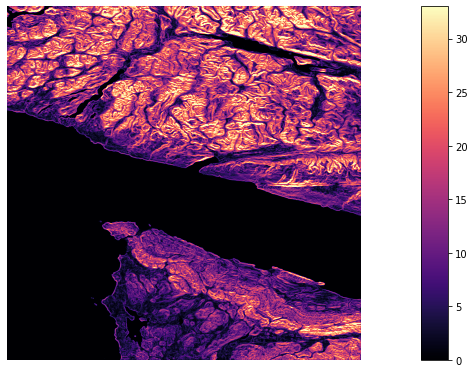

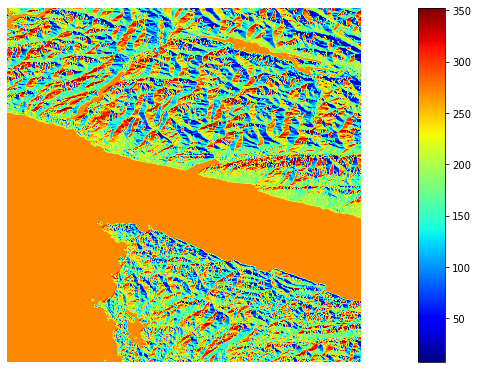

In [291]:
#Optional printing of tile slope and aspect
#convert to rdarray to get spatial information
#geo = np.array(-111.519667, 90, 0.0, 66.118, 0.0, -90)
#tilearray = rd.rdarray(tilearray, no_data=-9999, projection = 'EPSG:4326', geotransform = geo)

#get slope
#slope_arr = rd.TerrainAttribute(tilearray, attrib='slope_degrees')
#rd.rdShow(slope_arr, axes=False, cmap='magma', figsize=(8, 5.5))
#plt.show()

#get aspect value
#aspect_arr = rd.TerrainAttribute(tilearray, attrib='aspect')
#rd.rdShow(aspect_arr, axes=False, cmap='jet', figsize=(8, 5.5))
#plt.show()

In [ ]:
'''
Read in data to make stationary dataframe
'''

#Read Files into memory
TrainSWE = pd.read_hdf('Training_Data/SWE.h5', 'TrainSWE')
SWEdata = pd.read_hdf('Training_Data/SWE.h5', 'SWEdata')
GM_Train = pd.read_hdf('Training_Data/SWE.h5',  'GM_Train')
Snotel = pd.read_hdf('Training_Data/SWE.h5',  'Snotel')
#Read Files into memory
#read Geospatial data into memory
Geospatial_df = pd.read_hdf('Training_Data/SWE.h5', 'Geospatial_df')

#remove region as replacing with higher resolution version
del TrainSWE['Region']

#Fix date variable
GM_Train = GM_Train.rename(columns={'variable':'Date'})

In [460]:
'''
Build DF's, get geospatial information, process geospatial information (feature engineering),
Subset data into each region
Connect geospatial information to training and testing data
'''

"\nBuild DF's, get geospatial information, process geospatial information (feature engineering),\nSubset data into each region\nConnect geospatial information to training and testing data\n"

In [461]:
#Get geaspatial means
geospatialcols = ['_Coord_Long', '_Coord_Lat', '_Elevation_m', '_slope_Deg' , 'aspect_L']

#Training data
[mean_Geo(Geospatial_df, i) for i in geospatialcols]

#list of key geospatial component means
geocol = ['cell_id', '_Coord_Long','_Coord_Lat','_Elevation_m','_slope_Deg','aspect_L']
TrainGeo_df = Geospatial_df[geocol].copy()

#adjust column names to be consistent with snotel
TrainGeo_df = TrainGeo_df.rename( columns = {'_Coord_Long':'Long', '_Coord_Lat':'Lat', '_Elevation_m': 'elevation_m',
                               '_slope_Deg':'slope_deg' , 'aspect_L': 'aspect'})



In [ ]:
#Attach a region id for each location
TrainGeo_df['Region'] = 'other'
Snotel['Region'] = 'other'



Region_id(TrainGeo_df)
Region_id(Snotel)


In [ ]:
'''
Slice into regional DF's
This is currently to ensure different regions are correctly classified. Will have to perform slice again

'''
#subset data by each region into dictionary
RegionTrain = {name: TrainGeo_df.loc[TrainGeo_df['Region'] == name] for name in TrainGeo_df.Region.unique()}
RegionSnotel  = {name: Snotel.loc[Snotel['Region'] == name] for name in Snotel.Region.unique()}


In [ ]:
#check to make sure no test locations classified as other
print('Training') 
#look at region training sites
for i in RegionTrain.keys():
    print('There are', len(RegionTrain[i]), ' training locations in ', i)
    
print('         ') 
print('SNOTEL') 
#look at region training sites
for i in RegionSnotel.keys():
    print('There are', len(RegionSnotel[i]), ' Snotel locations in ', i)

In [ ]:
#save dictionaries as pkl
# create a binary pickle file 
RTrain = open("Training_Data/RegionTrain.pkl","wb")
Rsnow = open("Training_Data/RegionSnotel.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(RegionTrain,RTrain)
pickle.dump(RegionSnotel,Rsnow)

# close file
RTrain.close()
Rsnow.close()

In [ ]:
#load regionalized geospatial data
RegionTrain = open("Data/RegionTrain.pkl", "rb")
RegionSnotel = open("Data/RegionSnotel.pkl", "rb")

RegionTrain = pickle.load(RegionTrain)
RegionSnotel = pickle.load(RegionSnotel)

In [ ]:
GeoPlot(RegionTrain)

In [ ]:
GeoPlot(RegionSnotel)

In [ ]:
Snotel = Snotel.rename(columns = {'slope_Deg': 'slope_deg'})

In [ ]:
#Merge Geospatial data to SWE observations

Training = Geo_to_Data(TrainGeo_df, TrainSWE, 'cell_id')



# get snotel station id, region, slope, and aspect to merge with obervations
Snocol = ['station_id' ,'Region','slope_deg','aspect']
Snotel = Snotel[Snocol]
GM_Snotel_train = Geo_to_Data(Snotel, GM_Train, 'station_id')

#Make Date in datetime dtype
Testing['Date'] = pd.to_datetime(Testing['Date'])
GM_Snotel_train['Date'] = pd.to_datetime(GM_Snotel_train['Date'])

#add week number to observations
week_num(Training)


#Save Geospatial data into SWE.h5 file
GM_Snotel_train.to_hdf('Training_Data/SWE.h5', key = 'GM_Snotel_train')
Training.to_hdf('Training_Data/SWE.h5', key = 'Training')


In [472]:
#Connect observations to regional data
#subset data by each region into dictionary
RegionTrain = {name: Training.loc[Training['Region'] == name] for name in Training.Region.unique()}
RegionSnotel_Train  = {name: GM_Snotel_train.loc[GM_Snotel_train['Region'] == name] for name in GM_Snotel_train.Region.unique()}


#save dictionaries as pkl
# create a binary pickle file 
RTrain = open("Training_Data/RegionTrain.pkl","wb")
Rsnow_Train = open("Training_Data/RegionSnotel_Train.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(RegionTrain,RTrain)
pickle.dump(RegionSnotel_Train,Rsnow_Train)

# close file
RTrain.close()
Rsnow_Train.close()


In [14]:
#load regionalized geospatial data
RTrain = open("Training_Data/RegionTrain.pkl","rb")
Rsnow_Train = open("Training_Data/RegionSnotel_Train.pkl","rb")

RegionTrain = pickle.load(RTrain)
RegionSnotel_Train = pickle.load(Rsnow_Train)



In [15]:
#make northness feature and delete regions, slope, aspect features for each training and testing cell
for i in tqdm(RegionTrain):
    RegionTrain[i] = northness(RegionTrain[i])
    

  0%|          | 0/22 [00:00<?, ?it/s]/uufs/chpc.utah.edu/common/home/u1154915/software/pkg/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 22/22 [00:57<00:00,  2.60s/it]


In [16]:
#Make dictionary in Regions dict for each region's dictionary of Snotel sites
Regions = list(RegionTrain.keys()).copy()

In [17]:


#Make dictionary in Regions dict for each region's dictionary of Snotel sites
#Regions = list(RegionTrain.keys()).copy()

for i in tqdm(Regions):
    
    snotel = i+'_Snotel'
    RegionTrain[snotel] = {site: RegionSnotel_Train[i].loc[site] for site in RegionSnotel_Train[i].index.unique()}
    RegionTest[snotel] = {site: RegionSnotel_Test[i].loc[site] for site in RegionSnotel_Test[i].index.unique()}
    
    #get training and testing sites that are the same
    train = RegionTrain[snotel].keys()
    test = RegionTest[snotel].keys()

    as_set = set(train)
    intersection = as_set.intersection(test)
    
     #remove keys that are not shared
    Train = {k: RegionTrain[snotel][k] for k in intersection}
    Test = {k: RegionTest[snotel][k] for k in intersection}
    
    RegionTrain[snotel] = Train
    RegionTest[snotel] = Test
    

    #make Northing metric
    for j in intersection:
  #     
        RegionTrain[snotel][j] = northness(RegionTrain[snotel][j])
        RegionTest[snotel][j] = northness(RegionTest[snotel][j])
   
    #remove items we do not need
        RegionTrain[snotel][j] = RegionTrain[snotel][j].drop(columns = ['Long', 'Lat'])
        RegionTest[snotel][j] = RegionTest[snotel][j].drop(columns = ['Long', 'Lat'])
    #make date index
        RegionTrain[snotel][j] = RegionTrain[snotel][j].set_index('Date')
        RegionTest[snotel][j] = RegionTest[snotel][j].set_index('Date')
        
    #rename columns to represent site info
        colnames = RegionTrain[snotel][j].columns
        sitecolnames = [x +'_'+ j for x in colnames]
        names = dict(zip(colnames, sitecolnames))
        RegionTrain[snotel][j] = RegionTrain[snotel][j].rename(columns = names)
        RegionTest[snotel][j] = RegionTest[snotel][j].rename(columns = names)
    
    #Remove unused columns
    columns = list(RegionTrain[snotel].keys()).copy()
    for col in columns:
        if len(RegionTrain[snotel][col].columns) >4:
            del RegionTrain[snotel][col]
            
    columns = list(RegionTest[snotel].keys()).copy()        
    for col in columns:       
        if len(RegionTest[snotel][col].columns) >4:
            del RegionTest[snotel][col]
        

  0%|          | 0/22 [00:00<?, ?it/s]/uufs/chpc.utah.edu/common/home/u1154915/software/pkg/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/uufs/chpc.utah.edu/common/home/u1154915/software/pkg/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()
100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


In [18]:
#make a df for training each region, 

for R in tqdm(Regions):
    snotels = R+'_Snotel'
    RegionTrain[R] = RegionTrain[R].reset_index()
    RegionTrain[R] = RegionTrain[R].set_index('Date')
    
    RegionTest[R] = RegionTest[R].reset_index()
    RegionTest[R] = RegionTest[R].set_index('Date')
    
    
    for S in RegionTrain[snotels]:
        RegionTrain[R]= pd.concat([RegionTrain[R], RegionTrain[snotels][S].reindex(RegionTrain[R].index)], axis=1)
        RegionTest[R]= pd.concat([RegionTest[R], RegionTest[snotels][S].reindex(RegionTest[R].index)], axis=1)
    
    RegionTrain[R] = RegionTrain[R].fillna(-9999)
    RegionTest[R] = RegionTest[R].fillna(-9999)

100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


In [19]:
#save dictionaries as pkl
# create a binary pickle file 
#load regionalized geospatial data
RTrain = open("Training_Data/Training.pkl","wb")


# write the python object (dict) to pickle file
pickle.dump(RegionTest,Rtest)
pickle.dump(RegionTrain,RTrain)


# close file
Rtest.close()
RTrain.close()


In [ ]:
'''
Script for adding previous days SWE to cell and snotel
Adding snotel sites to training data, can use snotel sites to extend df to current
'''

In [15]:
#load regionalized geospatial data

RTrain = open("Training_Data/Training.pkl","rb")
RegionTrain = pickle.load(RTrain)

#RegionTrain['N_Sierras_Snotel']['SNOTEL:541_CA_SNTL']

Regions = ['N_Sierras', 'S_Sierras', 'Greater_Yellowstone', 'N_Co_Rockies', 
           'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade', 
           'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies',
           'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast',
           'Greater_Glacier', 'Or_Coast']

for region in Regions:
    RegionTrain[region] = RegionTrain[region].drop( RegionTrain[region].filter(regex='elevation_m_').columns, axis=1)
    RegionTrain[region] = RegionTrain[region].drop( RegionTrain[region].filter(regex='northness_').columns, axis=1)
    
    
Snotel = pd.read_hdf('Training_Data/SWE.h5',  'Snotel')
Snotel =Snotel.set_index('station_id')


In [18]:
for i in tqdm(Regions):
    Snotel_As_cellid(RegionTrain, i)

100%|██████████| 213/213 [00:00<00:00, 5830.97it/s]

100%|██████████| 210/210 [00:00<00:00, 5865.38it/s]

100%|██████████| 184/184 [00:00<00:00, 5945.38it/s]

100%|██████████| 177/177 [00:00<00:00, 7753.68it/s]

100%|██████████| 202/202 [00:00<00:00, 8853.37it/s]


N_Sierras



100%|██████████| 209/209 [00:00<00:00, 6094.85it/s]

100%|██████████| 213/213 [00:00<00:00, 5625.79it/s]

100%|██████████| 213/213 [00:00<00:00, 6634.44it/s]

100%|██████████| 213/213 [00:00<00:00, 8189.82it/s]

100%|██████████| 4/4 [00:00<00:00, 5257.67it/s]

100%|██████████| 211/211 [00:00<00:00, 6084.72it/s]

100%|██████████| 206/206 [00:00<00:00, 6193.03it/s]

100%|██████████| 187/187 [00:00<00:00, 6111.53it/s]

100%|██████████| 203/203 [00:00<00:00, 7812.63it/s]

100%|██████████| 195/195 [00:00<00:00, 6832.37it/s]

100%|██████████| 209/209 [00:00<00:00, 6217.79it/s]

100%|██████████| 213/213 [00:00<00:00, 6137.37it/s]

100%|██████████| 66/66 [00:00<00:00, 5619.31it/s]

100%|██████████| 205/205 [00:00<00:00, 8488.99it/s]

100%|██████████| 192/192 [00:00<00:00, 6831.35it/s]

100%|██████████| 213/213 [00:00<00:00, 6212.23it/s]

100%|██████████| 95/95 [00:00<00:00, 5872.38it/s]

100%|██████████| 197/197 [00:00<00:00, 6835.52it/s]

100%|██████████| 207/207 [00:00<00:00, 7395.66it/s]



S_Sierras


100%|██████████| 193/193 [00:00<00:00, 5990.53it/s]

100%|██████████| 200/200 [00:00<00:00, 7907.22it/s]

100%|██████████| 213/213 [00:00<00:00, 8006.76it/s]

100%|██████████| 213/213 [00:00<00:00, 6245.89it/s]

100%|██████████| 133/133 [00:00<00:00, 6226.41it/s]

100%|██████████| 211/211 [00:00<00:00, 8080.63it/s]

100%|██████████| 200/200 [00:00<00:00, 8198.81it/s]

100%|██████████| 201/201 [00:00<00:00, 6043.02it/s]

100%|██████████| 202/202 [00:00<00:00, 6093.30it/s]

100%|██████████| 205/205 [00:00<00:00, 7285.79it/s]

100%|██████████| 212/212 [00:00<00:00, 7799.45it/s]

100%|██████████| 209/209 [00:00<00:00, 7873.69it/s]

100%|██████████| 213/213 [00:00<00:00, 8286.06it/s]

100%|██████████| 204/204 [00:00<00:00, 8666.62it/s]

100%|██████████| 213/213 [00:00<00:00, 8738.56it/s]

100%|██████████| 203/203 [00:00<00:00, 8708.73it/s]

100%|██████████| 213/213 [00:00<00:00, 8740.87it/s]

100%|██████████| 213/213 [00:00<00:00, 6018.18it/s]

100%|██████████| 213/213 [00:00<00:00, 6077.87

Greater_Yellowstone



100%|██████████| 213/213 [00:00<00:00, 6661.00it/s]

100%|██████████| 213/213 [00:00<00:00, 6160.10it/s]

100%|██████████| 213/213 [00:00<00:00, 6240.22it/s]

100%|██████████| 213/213 [00:00<00:00, 7372.76it/s]

100%|██████████| 213/213 [00:00<00:00, 7486.00it/s]

100%|██████████| 213/213 [00:00<00:00, 6240.48it/s]

100%|██████████| 183/183 [00:00<00:00, 6165.81it/s]

100%|██████████| 213/213 [00:00<00:00, 7099.84it/s]

100%|██████████| 213/213 [00:00<00:00, 9072.40it/s]

100%|██████████| 175/175 [00:00<00:00, 8248.99it/s]

100%|██████████| 213/213 [00:00<00:00, 6324.24it/s]

100%|██████████| 213/213 [00:00<00:00, 6192.25it/s]

100%|██████████| 122/122 [00:00<00:00, 6140.93it/s]

100%|██████████| 213/213 [00:00<00:00, 7761.76it/s]

100%|██████████| 213/213 [00:00<00:00, 8025.32it/s]

100%|██████████| 213/213 [00:00<00:00, 5919.13it/s]

100%|██████████| 213/213 [00:00<00:00, 6054.15it/s]

100%|██████████| 213/213 [00:00<00:00, 6724.93it/s]

100%|██████████| 213/213 [00:00<00:00, 8980.0

N_Co_Rockies


100%|██████████| 213/213 [00:00<00:00, 6295.80it/s]

100%|██████████| 213/213 [00:00<00:00, 6369.60it/s]

100%|██████████| 213/213 [00:00<00:00, 7834.80it/s]

100%|██████████| 213/213 [00:00<00:00, 8931.37it/s]

100%|██████████| 213/213 [00:00<00:00, 5952.62it/s]

100%|██████████| 213/213 [00:00<00:00, 4784.61it/s]

100%|██████████| 213/213 [00:00<00:00, 7525.98it/s]

100%|██████████| 213/213 [00:00<00:00, 8759.21it/s]

100%|██████████| 187/187 [00:00<00:00, 6168.29it/s]

100%|██████████| 213/213 [00:00<00:00, 6272.02it/s]

100%|██████████| 213/213 [00:00<00:00, 6093.59it/s]

100%|██████████| 213/213 [00:00<00:00, 8972.36it/s]

100%|██████████| 213/213 [00:00<00:00, 7223.02it/s]

100%|██████████| 213/213 [00:00<00:00, 6169.24it/s]

100%|██████████| 213/213 [00:00<00:00, 6094.54it/s]

100%|██████████| 157/157 [00:00<00:00, 8205.17it/s]

100%|██████████| 213/213 [00:00<00:00, 9007.64it/s]

100%|██████████| 213/213 [00:00<00:00, 5458.20it/s]

100%|██████████| 213/213 [00:00<00:00, 6251.79

SW_Mont




100%|██████████| 213/213 [00:00<00:00, 6277.35it/s]

100%|██████████| 213/213 [00:00<00:00, 5693.81it/s]

100%|██████████| 213/213 [00:00<00:00, 8766.26it/s]

100%|██████████| 213/213 [00:00<00:00, 6581.55it/s]

100%|██████████| 213/213 [00:00<00:00, 6170.74it/s]

100%|██████████| 213/213 [00:00<00:00, 6294.83it/s]

100%|██████████| 213/213 [00:00<00:00, 7795.97it/s]

100%|██████████| 213/213 [00:00<00:00, 7647.75it/s]

100%|██████████| 213/213 [00:00<00:00, 6253.06it/s]

100%|██████████| 213/213 [00:00<00:00, 6287.69it/s]

100%|██████████| 213/213 [00:00<00:00, 7513.20it/s]

100%|██████████| 213/213 [00:00<00:00, 6313.33it/s]

100%|██████████| 213/213 [00:00<00:00, 6230.51it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

SW_Co_Rockies


100%|██████████| 213/213 [00:00<00:00, 6145.78it/s]

100%|██████████| 213/213 [00:00<00:00, 7611.78it/s]

100%|██████████| 213/213 [00:00<00:00, 7726.99it/s]

100%|██████████| 213/213 [00:00<00:00, 6166.69it/s]

100%|██████████| 213/213 [00:00<00:00, 6055.79it/s]

100%|██████████| 213/213 [00:00<00:00, 6287.34it/s]

100%|██████████| 213/213 [00:00<00:00, 8889.42it/s]

100%|██████████| 213/213 [00:00<00:00, 6550.19it/s]

100%|██████████| 213/213 [00:00<00:00, 6190.06it/s]

100%|██████████| 213/213 [00:00<00:00, 5816.05it/s]

100%|██████████| 213/213 [00:00<00:00, 8121.40it/s]

100%|██████████| 213/213 [00:00<00:00, 7022.10it/s]

100%|██████████| 213/213 [00:00<00:00, 6093.25it/s]

100%|██████████| 213/213 [00:00<00:00, 5884.51it/s]

100%|██████████| 213/213 [00:00<00:00, 6972.83it/s]

100%|██████████| 213/213 [00:00<00:00, 9244.86it/s]

100%|██████████| 213/213 [00:00<00:00, 9406.25it/s]

100%|██████████| 213/213 [00:00<00:00, 9299.43it/s]

100%|██████████| 157/157 [00:00<00:00, 9343.29

GBasin


100%|██████████| 213/213 [00:00<00:00, 6257.09it/s]

100%|██████████| 213/213 [00:00<00:00, 6209.46it/s]

100%|██████████| 213/213 [00:00<00:00, 6170.35it/s]

100%|██████████| 213/213 [00:00<00:00, 7627.83it/s]

100%|██████████| 213/213 [00:00<00:00, 8696.20it/s]

100%|██████████| 187/187 [00:00<00:00, 7277.59it/s]

100%|██████████| 213/213 [00:00<00:00, 7209.62it/s]

100%|██████████| 213/213 [00:00<00:00, 7188.90it/s]

100%|██████████| 213/213 [00:00<00:00, 7110.40it/s]

100%|██████████| 213/213 [00:00<00:00, 8069.68it/s]

100%|██████████| 213/213 [00:00<00:00, 6223.13it/s]

100%|██████████| 213/213 [00:00<00:00, 6169.16it/s]

100%|██████████| 213/213 [00:00<00:00, 6309.63it/s]

100%|██████████| 213/213 [00:00<00:00, 7869.38it/s]

100%|██████████| 213/213 [00:00<00:00, 6909.94it/s]

100%|██████████| 187/187 [00:00<00:00, 6371.89it/s]

100%|██████████| 213/213 [00:00<00:00, 6211.36it/s]

100%|██████████| 213/213 [00:00<00:00, 6685.33it/s]

100%|██████████| 213/213 [00:00<00:00, 7968.91

N_Wasatch


100%|██████████| 213/213 [00:00<00:00, 8456.74it/s]

100%|██████████| 213/213 [00:00<00:00, 6261.38it/s]

100%|██████████| 213/213 [00:00<00:00, 6229.03it/s]

100%|██████████| 213/213 [00:00<00:00, 6113.06it/s]

100%|██████████| 213/213 [00:00<00:00, 7620.48it/s]

100%|██████████| 213/213 [00:00<00:00, 8116.68it/s]

100%|██████████| 213/213 [00:00<00:00, 6127.31it/s]

100%|██████████| 213/213 [00:00<00:00, 6238.87it/s]

100%|██████████| 213/213 [00:00<00:00, 7213.92it/s]

100%|██████████| 213/213 [00:00<00:00, 7682.27it/s]

100%|██████████| 213/213 [00:00<00:00, 7994.37it/s]

100%|██████████| 213/213 [00:00<00:00, 7256.64it/s]

100%|██████████| 213/213 [00:00<00:00, 7199.56it/s]

100%|██████████| 213/213 [00:00<00:00, 7192.44it/s]

100%|██████████| 213/213 [00:00<00:00, 7692.26it/s]

100%|██████████| 213/213 [00:00<00:00, 8203.81it/s]

100%|██████████| 213/213 [00:00<00:00, 7206.77it/s]

100%|██████████| 213/213 [00:00<00:00, 7191.28it/s]

100%|██████████| 213/213 [00:00<00:00, 7266.44

N_Cascade




100%|██████████| 213/213 [00:00<00:00, 7467.10it/s]

100%|██████████| 213/213 [00:00<00:00, 6194.01it/s]

100%|██████████| 183/183 [00:00<00:00, 6092.84it/s]

100%|██████████| 213/213 [00:00<00:00, 6184.58it/s]

100%|██████████| 213/213 [00:00<00:00, 7583.54it/s]

100%|██████████| 213/213 [00:00<00:00, 6726.35it/s]

100%|██████████| 213/213 [00:00<00:00, 6121.60it/s]

100%|██████████| 213/213 [00:00<00:00, 5248.24it/s]

100%|██████████| 183/183 [00:00<00:00, 6861.59it/s]

100%|██████████| 213/213 [00:00<00:00, 8344.65it/s]

100%|██████████| 206/206 [00:00<00:00, 6127.89it/s]

100%|██████████| 213/213 [00:00<00:00, 6010.89it/s]

100%|██████████| 213/213 [00:00<00:00, 6144.00it/s]

100%|██████████| 213/213 [00:00<00:00, 7387.64it/s]

100%|██████████| 213/213 [00:00<00:00, 7590.63it/s]

100%|██████████| 213/213 [00:00<00:00, 6154.12it/s]

100%|██████████| 213/213 [00:00<00:00, 6076.51it/s]

100%|██████████| 159/159 [00:00<00:00, 6041.80it/s]

100%|██████████| 213/213 [00:00<00:00, 7921.

S_Wasatch


100%|██████████| 213/213 [00:00<00:00, 6039.05it/s]

100%|██████████| 213/213 [00:00<00:00, 7293.61it/s]

100%|██████████| 213/213 [00:00<00:00, 7541.10it/s]

100%|██████████| 213/213 [00:00<00:00, 6342.33it/s]

100%|██████████| 213/213 [00:00<00:00, 6097.87it/s]

100%|██████████| 213/213 [00:00<00:00, 6276.65it/s]

100%|██████████| 213/213 [00:00<00:00, 7895.88it/s]

100%|██████████| 213/213 [00:00<00:00, 7832.33it/s]

100%|██████████| 213/213 [00:00<00:00, 7878.95it/s]

100%|██████████| 213/213 [00:00<00:00, 7623.73it/s]

100%|██████████| 213/213 [00:00<00:00, 7906.01it/s]

100%|██████████| 95/95 [00:00<00:00, 7836.43it/s]

100%|██████████| 213/213 [00:00<00:00, 7808.64it/s]

100%|██████████| 213/213 [00:00<00:00, 7848.08it/s]

100%|██████████| 213/213 [00:00<00:00, 6649.94it/s]

100%|██████████| 213/213 [00:00<00:00, 6253.98it/s]

100%|██████████| 187/187 [00:00<00:00, 6048.89it/s]

100%|██████████| 213/213 [00:00<00:00, 6614.74it/s]

100%|██████████| 157/157 [00:00<00:00, 7910.36it

SW_Mtns


100%|██████████| 213/213 [00:00<00:00, 7253.05it/s]

100%|██████████| 213/213 [00:00<00:00, 8123.17it/s]

100%|██████████| 213/213 [00:00<00:00, 6170.61it/s]

100%|██████████| 213/213 [00:00<00:00, 6102.70it/s]

100%|██████████| 213/213 [00:00<00:00, 6322.80it/s]

100%|██████████| 213/213 [00:00<00:00, 8385.07it/s]

100%|██████████| 213/213 [00:00<00:00, 6643.76it/s]

100%|██████████| 126/126 [00:00<00:00, 5861.67it/s]

100%|██████████| 213/213 [00:00<00:00, 6061.17it/s]

100%|██████████| 213/213 [00:00<00:00, 6799.19it/s]

100%|██████████| 213/213 [00:00<00:00, 7806.87it/s]

100%|██████████| 213/213 [00:00<00:00, 6422.76it/s]

100%|██████████| 213/213 [00:00<00:00, 6066.36it/s]

100%|██████████| 213/213 [00:00<00:00, 5362.72it/s]

100%|██████████| 213/213 [00:00<00:00, 7913.85it/s]

100%|██████████| 213/213 [00:00<00:00, 9242.76it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

E_WA_N_Id_W_Mont


100%|██████████| 213/213 [00:00<00:00, 6140.33it/s]

100%|██████████| 199/199 [00:00<00:00, 6135.49it/s]

100%|██████████| 213/213 [00:00<00:00, 6967.72it/s]

100%|██████████| 213/213 [00:00<00:00, 8903.51it/s]

100%|██████████| 213/213 [00:00<00:00, 8913.90it/s]

100%|██████████| 213/213 [00:00<00:00, 8779.87it/s]

100%|██████████| 213/213 [00:00<00:00, 8825.58it/s]

100%|██████████| 213/213 [00:00<00:00, 8911.59it/s]

100%|██████████| 213/213 [00:00<00:00, 8753.12it/s]

100%|██████████| 213/213 [00:00<00:00, 8791.10it/s]

100%|██████████| 213/213 [00:00<00:00, 8414.52it/s]

100%|██████████| 213/213 [00:00<00:00, 6168.65it/s]

100%|██████████| 213/213 [00:00<00:00, 6098.54it/s]

100%|██████████| 213/213 [00:00<00:00, 6051.65it/s]

100%|██████████| 213/213 [00:00<00:00, 7804.00it/s]

100%|██████████| 213/213 [00:00<00:00, 7290.81it/s]

100%|██████████| 207/207 [00:00<00:00, 6054.20it/s]

100%|██████████| 157/157 [00:00<00:00, 6257.06it/s]

100%|██████████| 213/213 [00:00<00:00, 6611.22

S_Wyoming



100%|██████████| 213/213 [00:00<00:00, 7395.28it/s]

100%|██████████| 213/213 [00:00<00:00, 7523.13it/s]

100%|██████████| 213/213 [00:00<00:00, 6232.34it/s]

100%|██████████| 213/213 [00:00<00:00, 6129.12it/s]

100%|██████████| 213/213 [00:00<00:00, 6472.03it/s]

100%|██████████| 213/213 [00:00<00:00, 8802.36it/s]

100%|██████████| 213/213 [00:00<00:00, 6461.55it/s]

100%|██████████| 213/213 [00:00<00:00, 6165.97it/s]

100%|██████████| 213/213 [00:00<00:00, 6174.87it/s]

100%|██████████| 213/213 [00:00<00:00, 7477.35it/s]

100%|██████████| 213/213 [00:00<00:00, 6279.91it/s]

100%|██████████| 213/213 [00:00<00:00, 6236.86it/s]

100%|██████████| 213/213 [00:00<00:00, 6300.15it/s]

100%|██████████| 213/213 [00:00<00:00, 7785.64it/s]

SE_Co_Rockies




100%|██████████| 213/213 [00:00<00:00, 7126.80it/s]

100%|██████████| 213/213 [00:00<00:00, 6177.65it/s]

100%|██████████| 213/213 [00:00<00:00, 6357.90it/s]

100%|██████████| 213/213 [00:00<00:00, 6752.33it/s]

100%|██████████| 213/213 [00:00<00:00, 8679.64it/s]

100%|██████████| 187/187 [00:00<00:00, 5319.94it/s]

100%|██████████| 213/213 [00:00<00:00, 6256.87it/s]

100%|██████████| 213/213 [00:00<00:00, 6142.69it/s]

100%|██████████| 213/213 [00:00<00:00, 8209.77it/s]

100%|██████████| 213/213 [00:00<00:00, 7543.90it/s]

100%|██████████| 213/213 [00:00<00:00, 6382.06it/s]

100%|██████████| 213/213 [00:00<00:00, 6240.22it/s]

100%|██████████| 213/213 [00:00<00:00, 6006.28it/s]

100%|██████████| 213/213 [00:00<00:00, 9038.72it/s]

100%|██████████| 213/213 [00:00<00:00, 8158.41it/s]

100%|██████████| 35/35 [00:00<00:00, 5822.42it/s]

100%|██████████| 213/213 [00:00<00:00, 6298.55it/s]

100%|██████████| 213/213 [00:00<00:00, 7517.94it/s]

100%|██████████| 213/213 [00:00<00:00, 8156.47

Sawtooth


100%|██████████| 213/213 [00:00<00:00, 5332.67it/s]

100%|██████████| 186/186 [00:00<00:00, 7232.30it/s]

100%|██████████| 213/213 [00:00<00:00, 8609.96it/s]

100%|██████████| 213/213 [00:00<00:00, 7389.84it/s]

100%|██████████| 212/212 [00:00<00:00, 7183.19it/s]

100%|██████████| 213/213 [00:00<00:00, 7250.04it/s]

100%|██████████| 213/213 [00:00<00:00, 6958.22it/s]

100%|██████████| 213/213 [00:00<00:00, 7788.22it/s]

100%|██████████| 213/213 [00:00<00:00, 8013.01it/s]

100%|██████████| 213/213 [00:00<00:00, 7207.35it/s]

100%|██████████| 213/213 [00:00<00:00, 7202.99it/s]

100%|██████████| 213/213 [00:00<00:00, 7172.57it/s]

100%|██████████| 213/213 [00:00<00:00, 7634.09it/s]

100%|██████████| 213/213 [00:00<00:00, 8182.92it/s]

100%|██████████| 213/213 [00:00<00:00, 7220.28it/s]

100%|██████████| 213/213 [00:00<00:00, 6443.14it/s]

100%|██████████| 213/213 [00:00<00:00, 6057.93it/s]

100%|██████████| 213/213 [00:00<00:00, 7806.53it/s]

100%|██████████| 213/213 [00:00<00:00, 8372.26

Ca_Coast
E_Or




100%|██████████| 213/213 [00:00<00:00, 8932.62it/s]

100%|██████████| 213/213 [00:00<00:00, 9096.14it/s]

100%|██████████| 213/213 [00:00<00:00, 8947.29it/s]

100%|██████████| 213/213 [00:00<00:00, 8994.04it/s]

100%|██████████| 213/213 [00:00<00:00, 8956.80it/s]

100%|██████████| 213/213 [00:00<00:00, 6380.83it/s]

100%|██████████| 210/210 [00:00<00:00, 6116.14it/s]

100%|██████████| 213/213 [00:00<00:00, 4914.98it/s]

100%|██████████| 213/213 [00:00<00:00, 7793.04it/s]

100%|██████████| 213/213 [00:00<00:00, 7477.29it/s]

100%|██████████| 213/213 [00:00<00:00, 6156.28it/s]

100%|██████████| 213/213 [00:00<00:00, 6171.89it/s]

100%|██████████| 213/213 [00:00<00:00, 6073.87it/s]

100%|██████████| 213/213 [00:00<00:00, 7824.17it/s]

100%|██████████| 213/213 [00:00<00:00, 7259.77it/s]

100%|██████████| 213/213 [00:00<00:00, 6212.06it/s]

100%|██████████| 213/213 [00:00<00:00, 6108.92it/s]

100%|██████████| 213/213 [00:00<00:00, 6483.59it/s]

100%|██████████| 213/213 [00:00<00:00, 7736.

N_Yellowstone



100%|██████████| 213/213 [00:00<00:00, 6101.66it/s]

100%|██████████| 213/213 [00:00<00:00, 6181.58it/s]

100%|██████████| 213/213 [00:00<00:00, 7680.75it/s]

100%|██████████| 213/213 [00:00<00:00, 7110.35it/s]

100%|██████████| 213/213 [00:00<00:00, 6241.61it/s]

100%|██████████| 213/213 [00:00<00:00, 6921.45it/s]

100%|██████████| 213/213 [00:00<00:00, 8011.29it/s]

100%|██████████| 213/213 [00:00<00:00, 6009.60it/s]

100%|██████████| 213/213 [00:00<00:00, 6125.88it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

S_Cascade


100%|██████████| 205/205 [00:00<00:00, 6109.50it/s]

100%|██████████| 213/213 [00:00<00:00, 7972.25it/s]

100%|██████████| 213/213 [00:00<00:00, 6390.65it/s]

100%|██████████| 213/213 [00:00<00:00, 5303.98it/s]

100%|██████████| 213/213 [00:00<00:00, 6120.68it/s]

100%|██████████| 213/213 [00:00<00:00, 7822.66it/s]

100%|██████████| 213/213 [00:00<00:00, 7364.07it/s]

100%|██████████| 213/213 [00:00<00:00, 6165.41it/s]

100%|██████████| 213/213 [00:00<00:00, 6244.18it/s]

100%|██████████| 213/213 [00:00<00:00, 6882.64it/s]

100%|██████████| 213/213 [00:00<00:00, 8190.80it/s]

100%|██████████| 213/213 [00:00<00:00, 6108.63it/s]

100%|██████████| 213/213 [00:00<00:00, 5996.05it/s]

100%|██████████| 213/213 [00:00<00:00, 6122.74it/s]

100%|██████████| 213/213 [00:00<00:00, 8136.27it/s]

100%|██████████| 213/213 [00:00<00:00, 7247.87it/s]

100%|██████████| 213/213 [00:00<00:00, 6171.25it/s]

100%|██████████| 213/213 [00:00<00:00, 6195.30it/s]

100%|██████████| 213/213 [00:00<00:00, 6668.41

Wa_Coast
Greater_Glacier


100%|██████████| 213/213 [00:00<00:00, 8725.08it/s]

100%|██████████| 213/213 [00:00<00:00, 7157.80it/s]

100%|██████████| 213/213 [00:00<00:00, 7172.92it/s]

100%|██████████| 213/213 [00:00<00:00, 7143.49it/s]

100%|██████████| 213/213 [00:00<00:00, 7392.46it/s]

100%|██████████| 213/213 [00:00<00:00, 8749.69it/s]

100%|██████████| 213/213 [00:00<00:00, 7194.00it/s]

100%|██████████| 213/213 [00:00<00:00, 7196.49it/s]

100%|██████████| 213/213 [00:00<00:00, 6546.25it/s]

100%|██████████| 213/213 [00:00<00:00, 7385.68it/s]

100%|██████████| 213/213 [00:00<00:00, 8616.44it/s]

100%|██████████| 213/213 [00:00<00:00, 8640.10it/s]

100%|██████████| 213/213 [00:00<00:00, 8785.14it/s]

100%|██████████| 213/213 [00:00<00:00, 8697.39it/s]

100%|██████████| 212/212 [00:00<00:00, 8819.08it/s]

100%|██████████| 213/213 [00:00<00:00, 8741.98it/s]

100%|██████████| 213/213 [00:00<00:00, 8915.15it/s]

100%|██████████| 213/213 [00:00<00:00, 8786.34it/s]

100%|██████████| 22/22 [00:28<00:00,  1.31s/it

Or_Coast


In [20]:
file = 'Training_Data/Train_PrevSWE.h5'

path = 'Training_Data/Train_PrevSWE.h5'

for regions in Regions:
    Prev_SWE(file, path, regions)

  4%|▎         | 2/54 [00:00<00:03, 14.53it/s]

N_Sierras


  0%|          | 0/4982 [00:00<?, ?it/s]

S_Sierras


 50%|█████     | 2509/4982 [00:30<00:57, 43.38it/s]

Date                 2018-04-25 00:00:00
Long                         -119.657693
Lat                            37.819463
elevation_m                      2648.25
SWE                                 13.4
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 07c3a503-1709-41cf-adfd-7e0ed0ad87f8, Length: 162, dtype: object (162,)


 51%|█████     | 2524/4982 [00:30<02:08, 19.17it/s]

Date                 2018-04-25 00:00:00
Long                         -119.253451
Lat                            37.734259
elevation_m                       3548.5
SWE                                 16.1
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 1175a1b4-abc2-42c0-ab9d-0763a27ea321, Length: 162, dtype: object (162,)


 61%|██████    | 3040/4982 [01:03<02:08, 15.07it/s]

Date                 2018-04-26 00:00:00
Long                         -118.391068
Lat                             36.95584
elevation_m                      3596.75
SWE                                  5.6
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 1f240cb2-8185-4279-9487-94f8df63d8fb, Length: 162, dtype: object (162,)


 71%|███████   | 3522/4982 [01:38<02:02, 11.88it/s]

Date                 2018-04-26 00:00:00
Long                         -118.418018
Lat                            37.013246
elevation_m                       3824.5
SWE                                  6.4
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 79a6ff1e-e65f-4a15-b43d-263b17fc3020, Length: 162, dtype: object (162,)


 73%|███████▎  | 3660/4982 [01:50<01:50, 11.97it/s]

Date                 2018-04-26 00:00:00
Long                         -119.010906
Lat                            36.682572
elevation_m                      1236.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 8f9536bf-e92f-49aa-b47b-ad46b75bee0a, Length: 162, dtype: object (162,)


 97%|█████████▋| 4852/4982 [03:43<00:13,  9.39it/s]

Date                 2019-06-04 00:00:00
Long                         -119.657693
Lat                            37.627617
elevation_m                       2075.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 02e67538-8250-4463-8674-256848706fe3, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.657693
Lat                            37.620502
elevation_m                      1965.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 03887d4f-9286-

 97%|█████████▋| 4854/4982 [03:43<00:13,  9.27it/s]

Date                 2019-06-04 00:00:00
Long                         -119.684642
Lat                             37.65607
elevation_m                       2115.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 045980ac-670d-4757-990b-b739ea4fcf1f, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.540912
Lat                            37.599153
elevation_m                      2570.75
SWE                                 23.1
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 0655a095-1836-

 97%|█████████▋| 4856/4982 [03:43<00:13,  9.18it/s]

Date                 2019-06-04 00:00:00
Long                         -119.558878
Lat                            37.599153
elevation_m                      2442.25
SWE                                  3.3
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 15f3bb2d-d92d-44b7-be0e-c2ad3042efb1, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.666676
Lat                             37.60627
elevation_m                       1968.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 17a8460b-e7a8-

 98%|█████████▊| 4860/4982 [03:44<00:13,  9.38it/s]

Date                 2019-06-04 00:00:00
Long                         -119.406164
Lat                            37.613386
elevation_m                      2968.75
SWE                                 31.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 22037fcc-e3c6-4df0-9bf7-0ebb0f86ed8c, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.675659
Lat                            37.769773
elevation_m                      2406.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 24b7bd55-74de-

 98%|█████████▊| 4862/4982 [03:44<00:12,  9.30it/s]

Date                 2019-06-04 00:00:00
Long                          -119.45108
Lat                            37.592035
elevation_m                      2807.75
SWE                                 34.9
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 2e4073af-e39c-4a1b-aa0a-e035976c0d18, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.711592
Lat                            37.584917
elevation_m                      1171.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 33f1babe-c87d-

 98%|█████████▊| 4864/4982 [03:44<00:12,  9.22it/s]

Date                 2019-06-04 00:00:00
Long                         -119.693625
Lat                            37.783973
elevation_m                      2333.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 36bf1c5c-4fd8-426d-8b36-e993d6d9883a, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.702608
Lat                            37.762671
elevation_m                       2224.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 371e2dbe-683b-

 98%|█████████▊| 4866/4982 [03:44<00:12,  9.23it/s]

Date                 2019-06-04 00:00:00
Long                         -119.567861
Lat                            37.599153
elevation_m                      2422.75
SWE                                  4.5
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 45f27064-0707-4af6-974b-894a57f2b590, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.711592
Lat                            37.599153
elevation_m                      1111.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 48779aac-3bb3-

 98%|█████████▊| 4868/4982 [03:45<00:12,  9.17it/s]

Date                 2019-06-04 00:00:00
Long                         -119.720575
Lat                            37.741363
elevation_m                      1877.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 4cfb2b9a-ba99-4bf3-8209-6904d8dae70b, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.711592
Lat                             37.65607
elevation_m                       1781.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 4db736a0-afe4-

 98%|█████████▊| 4870/4982 [03:45<00:12,  9.08it/s]

Date                 2019-06-04 00:00:00
Long                         -119.594811
Lat                            37.599153
elevation_m                      2379.75
SWE                                  2.1
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 4f3b78ce-a1f5-4fab-8492-56f436503f03, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.684642
Lat                            37.634731
elevation_m                      1793.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 580a084b-7e64-

 98%|█████████▊| 4872/4982 [03:45<00:12,  9.05it/s]

Date                 2019-06-04 00:00:00
Long                         -119.711592
Lat                            37.613386
elevation_m                      1200.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 5a991e32-98d9-4eee-88e6-644f06eadf37, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.720575
Lat                            37.684512
elevation_m                       1316.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 61503ccd-2707-

 98%|█████████▊| 4874/4982 [03:45<00:11,  9.08it/s]

Date                 2019-06-04 00:00:00
Long                         -119.639726
Lat                            37.634731
elevation_m                       2109.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 6ad4af8a-d36a-48d9-9a54-0f7fbf642a0f, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.684642
Lat                            37.663181
elevation_m                      2146.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 6ade3f26-b053-

 98%|█████████▊| 4876/4982 [03:46<00:11,  9.12it/s]

Date                 2019-06-04 00:00:00
Long                         -119.576844
Lat                            37.599153
elevation_m                      2440.25
SWE                                  3.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 72b59a1f-be0c-4edb-88e5-26b105ad9372, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.711592
Lat                            37.670292
elevation_m                      1676.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 73936e8f-6ccd-

 98%|█████████▊| 4878/4982 [03:46<00:11,  9.13it/s]

Date                 2019-06-04 00:00:00
Long                         -119.639726
Lat                            37.592035
elevation_m                       2126.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 7943dcf7-4102-4bb4-a682-9cccc1b17e94, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.675659
Lat                            37.684512
elevation_m                      2064.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 7bdf6c32-2af1-

 98%|█████████▊| 4880/4982 [03:46<00:11,  9.12it/s]

Date                 2019-06-04 00:00:00
Long                         -119.684642
Lat                            37.670292
elevation_m                       2137.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 7d8da768-ff4f-47d8-9975-f2e557213d73, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.657693
Lat                            37.592035
elevation_m                      1862.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 7fdc65cd-6c3a-

 98%|█████████▊| 4882/4982 [03:46<00:11,  9.07it/s]

Date                 2019-06-04 00:00:00
Long                         -119.711592
Lat                             37.60627
elevation_m                       1129.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 81b8f0bd-c88e-484c-98ba-33889d783471, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.442097
Lat                            37.599153
elevation_m                      2723.25
SWE                                 23.8
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 8927f5c4-f12c-

 98%|█████████▊| 4884/4982 [03:46<00:10,  9.17it/s]

Date                 2019-06-04 00:00:00
Long                         -119.666676
Lat                            37.805269
elevation_m                       2502.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 8dd0e54e-bd6c-4982-8a27-4fb212cface0, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.603794
Lat                            37.599153
elevation_m                      2349.75
SWE                                  7.7
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 91c680bb-50c7-

 98%|█████████▊| 4886/4982 [03:47<00:10,  9.11it/s]

Date                 2019-06-04 00:00:00
Long                         -119.684642
Lat                            37.791073
elevation_m                       2367.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 96b0aa5d-37a6-4dfe-a611-cd08d18475a4, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.469046
Lat                            37.592035
elevation_m                       2756.0
SWE                                 25.5
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 96e0c491-b591-

 98%|█████████▊| 4888/4982 [03:47<00:10,  9.12it/s]

Date                 2019-06-04 00:00:00
Long                         -119.415148
Lat                            37.599153
elevation_m                      2717.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 9b2fae44-d70c-43f0-ae0d-43977cbd782e, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.711592
Lat                            37.755569
elevation_m                       2122.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: 9c2212f9-53ef-

 98%|█████████▊| 4892/4982 [03:47<00:09,  9.44it/s]

Date                 2019-06-04 00:00:00
Long                         -119.630743
Lat                            37.592035
elevation_m                      2268.75
SWE                                  0.1
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: a3ced6aa-0144-47c7-b443-2543fcf485d2, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.397181
Lat                             37.60627
elevation_m                      2865.75
SWE                                 20.2
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: a514f7fb-f13c-

 98%|█████████▊| 4894/4982 [03:48<00:09,  9.38it/s]

Date                 2019-06-04 00:00:00
Long                         -119.720575
Lat                            37.769773
elevation_m                      2205.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: b82001df-df21-467a-a9ff-75a00b37799a, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.702608
Lat                            37.599153
elevation_m                      1255.25
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: c0a2517b-09fe-

 98%|█████████▊| 4896/4982 [03:48<00:09,  9.36it/s]

Date                 2019-06-04 00:00:00
Long                         -119.684642
Lat                            37.599153
elevation_m                       1667.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: d348e71f-5019-4880-b161-87d2683ba634, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.648709
Lat                            37.627617
elevation_m                       2049.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: d595a388-3c44-

 98%|█████████▊| 4898/4982 [03:48<00:09,  9.33it/s]

Date                 2019-06-04 00:00:00
Long                         -119.442097
Lat                             37.60627
elevation_m                       2781.5
SWE                                 29.9
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: d6a1b724-d117-4133-901a-5a84c6875e2b, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.666676
Lat                            37.627617
elevation_m                       1970.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: d6c5bcc5-0783-

 98%|█████████▊| 4900/4982 [03:48<00:08,  9.27it/s]

Date                 2019-06-04 00:00:00
Long                         -119.388198
Lat                             37.60627
elevation_m                       2956.0
SWE                                  3.4
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: e411d8a7-76a1-407c-8b9a-33d8edad3a8d, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.666676
Lat                            37.599153
elevation_m                      1894.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: e683ce8c-2d11-

 98%|█████████▊| 4902/4982 [03:48<00:08,  9.22it/s]

Date                 2019-06-04 00:00:00
Long                         -119.406164
Lat                             37.60627
elevation_m                       2857.0
SWE                                 20.2
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: e6bc459a-f9ce-4b31-932e-2fe5efb3d28c, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.693625
Lat                            37.620502
elevation_m                       1625.0
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: e7f6383d-72b2-

 98%|█████████▊| 4904/4982 [03:49<00:08,  9.17it/s]

Date                 2019-06-04 00:00:00
Long                         -119.639726
Lat                            37.620502
elevation_m                      1989.75
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: f8ac5c72-a6ef-45ec-8275-68076a3b7276, Length: 162, dtype: object (162,)
Date                 2019-06-04 00:00:00
Long                         -119.684642
Lat                            37.769773
elevation_m                       2347.5
SWE                                  0.0
                            ...         
Prev_SWE_CDEC:CXS                    NaN
Prev_SWE_CDEC:PSC                    NaN
Prev_SWE_CDEC:SPT                    NaN
Prev_SWE_CDEC:WWC                    NaN
prev_SWE                        -9999.99
Name: fd0cf494-eb56-

  3%|▎         | 2/75 [00:00<00:05, 13.68it/s]

Greater_Yellowstone


  0%|          | 2/1815 [00:00<02:12, 13.64it/s]

N_Co_Rockies


 56%|█████▋    | 1022/1815 [00:04<00:02, 328.58it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.793818
Lat                                       38.743197
elevation_m                                  2901.5
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 008bbce5-1193-41c0-bda1-7ae421f700b8, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                     -107.00043
Lat                                       39.092662
elevation_m                                  3648.0
SWE                                            47.1
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 58%|█████▊    | 1055/1815 [00:04<00:04, 188.50it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.757885
Lat                                       38.869203
elevation_m                                  3347.5
SWE                                            19.4
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 0f992b2f-1f0f-4414-8c0a-8c39ff77e885, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.784835
Lat                                       38.708156
elevation_m                                  2664.5
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 60%|█████▉    | 1081/1815 [00:04<00:05, 134.44it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.739919
Lat                                       39.092662
elevation_m                                  3391.0
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 28963818-3055-4f4c-b433-16d01c680fb7, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -107.242975
Lat                                        38.65907
elevation_m                                  3184.5
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 61%|██████    | 1102/1815 [00:04<00:06, 108.88it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.739919
Lat                                       38.743197
elevation_m                                 2806.25
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 386864fe-20f1-44d9-b855-e6fa6a8106c2, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.820767
Lat                                       38.645039
elevation_m                                 2680.25
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 62%|██████▏   | 1119/1815 [00:05<00:07, 96.27it/s] 

Date                            2019-04-07 00:00:00
Long                                    -106.730936
Lat                                        38.65907
elevation_m                                 2819.75
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 45839b3c-b615-41e0-af3f-c5b39c244cdd, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.730936
Lat                                       38.764214
elevation_m                                  3070.0
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 62%|██████▏   | 1133/1815 [00:05<00:07, 89.87it/s]

Date                            2019-04-07 00:00:00
Long                                    -107.117211
Lat                                       38.652055
elevation_m                                 3260.25
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 52ef8a00-e858-43ee-a0d8-b3c455797d4b, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.721953
Lat                                       39.092662
elevation_m                                  3620.0
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 64%|██████▎   | 1157/1815 [00:05<00:08, 81.63it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.730936
Lat                                       38.715166
elevation_m                                  2950.0
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 5b7447c1-3270-4b38-990f-c9b1bbe2682f, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.802801
Lat                                       38.694135
elevation_m                                 2816.25
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 65%|██████▍   | 1176/1815 [00:05<00:08, 75.57it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.766868
Lat                                       38.841221
elevation_m                                 3177.75
SWE                                            15.5
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 6645616e-f98a-48c8-adff-f808fcbaee1b, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -107.009413
Lat                                       38.645039
elevation_m                                  2641.5
SWE                                             5.2
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 65%|██████▌   | 1185/1815 [00:06<00:08, 75.54it/s]

Date                            2019-04-07 00:00:00
Long                                    -107.090262
Lat                                       38.638023
elevation_m                                 2875.75
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 706f3325-edd6-47fa-8074-e7200aaae2b0, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.775851
Lat                                       38.652055
elevation_m                                 3056.75
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 66%|██████▌   | 1202/1815 [00:06<00:08, 75.27it/s]

Date                            2019-04-07 00:00:00
Long                                     -107.19806
Lat                                       38.680111
elevation_m                                 3589.25
SWE                                            11.7
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 82b1dfed-6cf6-4c55-90cb-5c5b45835346, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.721953
Lat                                       38.736191
elevation_m                                 2818.75
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 67%|██████▋   | 1219/1815 [00:06<00:07, 76.26it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.748902
Lat                                       38.876197
elevation_m                                  3261.0
SWE                                             8.5
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 930fab47-bf79-4250-9def-25595d7e7f33, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.739919
Lat                                       38.939109
elevation_m                                 3663.75
SWE                                            35.9
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 68%|██████▊   | 1243/1815 [00:06<00:07, 75.56it/s]

Date                            2019-04-07 00:00:00
Long                                    -107.225009
Lat                                       38.680111
elevation_m                                 3246.75
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 9e4ce09d-bd4c-43a5-9985-0196292fa50f, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.739919
Lat                                       39.064768
elevation_m                                 3396.25
SWE                                             3.1
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 69%|██████▉   | 1259/1815 [00:07<00:07, 74.70it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.784835
Lat                                       39.099633
elevation_m                                 3341.75
SWE                                            22.2
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: a8861153-d258-4198-bbaa-85eeece60861, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.730936
Lat                                       38.736191
elevation_m                                 2748.25
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 70%|███████   | 1275/1815 [00:07<00:07, 74.97it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.730936
Lat                                       39.106605
elevation_m                                  3196.5
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: b285143b-b86d-47d9-8e26-2e5799091a1c, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -107.045346
Lat                                       38.645039
elevation_m                                 3005.25
SWE                                            13.7
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 71%|███████   | 1291/1815 [00:07<00:07, 74.64it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.748902
Lat                                       38.848217
elevation_m                                  3361.5
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: c38482c9-49be-453f-8a67-a19c740afd53, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -107.108228
Lat                                       38.666084
elevation_m                                  3066.0
SWE                                             5.9
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 72%|███████▏  | 1307/1815 [00:07<00:06, 73.38it/s]

Date                            2019-04-07 00:00:00
Long                                    -107.233992
Lat                                       38.694135
elevation_m                                  3218.5
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: cfc831a0-42d3-4e64-9731-3131db8b41f0, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -107.144161
Lat                                       38.680111
elevation_m                                 3468.75
SWE                                            36.2
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 73%|███████▎  | 1324/1815 [00:07<00:06, 74.13it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.748902
Lat                                       38.673098
elevation_m                                  2720.0
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: e0d603ca-509f-40d3-94a1-76d88d715d5a, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -107.108228
Lat                                        38.65907
elevation_m                                  3027.0
SWE                                            26.7
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 74%|███████▍  | 1340/1815 [00:08<00:06, 72.79it/s]

Date                            2019-04-07 00:00:00
Long                                    -107.242975
Lat                                       38.743197
elevation_m                                 3127.75
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: f14b4c2c-6a2b-4ac8-8ec2-6ba4375ccc15, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.757885
Lat                                       38.715166
elevation_m                                 2776.25
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 75%|███████▍  | 1356/1815 [00:08<00:06, 72.22it/s]

Date                            2019-04-07 00:00:00
Long                                    -106.712969
Lat                                       38.708156
elevation_m                                 3189.75
SWE                                             0.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: fa749703-523d-41de-8f64-ee1ebfe7e687, Length: 122, dtype: object (122,)
Date                            2019-04-07 00:00:00
Long                                    -106.739919
Lat                                       38.904165
elevation_m                                 3352.25
SWE                                             9.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

 97%|█████████▋| 1755/1815 [00:13<00:00, 72.79it/s]

Date                            2019-06-24 00:00:00
Long                                     -106.17398
Lat                                       39.370993
elevation_m                                  3519.5
SWE                                             0.8
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL                     NaN
Prev_SWE_SNOTEL:717_CO_SNTL                     NaN
Prev_SWE_SNOTEL:1033_CO_SNTL                    NaN
Prev_SWE_SNOTEL:658_CO_SNTL                     NaN
prev_SWE                                   -9999.99
Name: 0d3e4edc-f642-4946-881b-6902787926ed, Length: 122, dtype: object (122,)
Date                            2019-06-24 00:00:00
Long                                    -106.182963
Lat                                       39.370993
elevation_m                                  3481.5
SWE                                             1.0
                                       ...         
Prev_SWE_SNOTEL:937_CO_SNTL           

  8%|▊         | 2/25 [00:00<00:01, 16.03it/s]

SW_Mont


  0%|          | 2/1201 [00:00<01:22, 14.53it/s]

SW_Co_Rockies


  3%|▎         | 31/1201 [00:00<00:57, 20.41it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.081279
Lat                                       37.783973
elevation_m                                  2953.0
SWE                                             0.7
WYWeek                                           26
northness                                 -0.177876
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

  8%|▊         | 99/1201 [00:00<00:21, 50.64it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.982464
Lat                                       37.670292
elevation_m                                 3238.25
SWE                                             2.3
WYWeek                                           26
northness                                 -0.088791
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 12%|█▏        | 145/1201 [00:01<00:12, 83.64it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.182963
Lat                                       37.077776
elevation_m                                  2854.5
SWE                                             0.0
WYWeek                                           26
northness                                 -0.014708
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 16%|█▌        | 190/1201 [00:01<00:08, 122.40it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.045346
Lat                                       37.684512
elevation_m                                 2752.25
SWE                                             0.3
WYWeek                                           26
northness                                 -0.062054
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 18%|█▊        | 212/1201 [00:01<00:07, 138.90it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.407542
Lat                                       37.156571
elevation_m                                  3036.0
SWE                                             0.1
WYWeek                                           26
northness                                 -0.320345
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 23%|██▎       | 279/1201 [00:01<00:05, 182.46it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.569239
Lat                                       37.748467
elevation_m                                 2930.75
SWE                                             0.5
WYWeek                                           26
northness                                 -0.070178
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 25%|██▌       | 303/1201 [00:01<00:04, 195.24it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.865683
Lat                                       37.499443
elevation_m                                  3424.0
SWE                                            26.6
WYWeek                                           26
northness                                 -0.150352
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 29%|██▉       | 350/1201 [00:02<00:04, 208.36it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.587205
Lat                                        37.65607
elevation_m                                  2703.5
SWE                                             0.4
WYWeek                                           26
northness                                 -0.034715
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 33%|███▎      | 396/1201 [00:02<00:03, 211.10it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.506357
Lat                                       37.349629
elevation_m                                  3092.5
SWE                                             1.7
WYWeek                                           26
northness                                 -0.262003
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 37%|███▋      | 440/1201 [00:02<00:03, 212.56it/s]

Date                            2016-04-03 00:00:00
Long                                     -107.17111
Lat                                        37.89748
elevation_m                                  3162.0
SWE                                             7.2
WYWeek                                           26
northness                                 -0.080835
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 41%|████      | 489/1201 [00:02<00:03, 225.04it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.569239
Lat                                       37.805269
elevation_m                                  2890.5
SWE                                             0.0
WYWeek                                           26
northness                                 -0.131609
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 45%|████▌     | 541/1201 [00:02<00:02, 227.33it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.326694
Lat                                       37.156571
elevation_m                                 2993.75
SWE                                             1.6
WYWeek                                           26
northness                                 -0.173514
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 49%|████▉     | 588/1201 [00:03<00:02, 216.82it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.144161
Lat                                       37.862028
elevation_m                                  3113.5
SWE                                             2.9
WYWeek                                           26
northness                                 -0.026208
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 53%|█████▎    | 632/1201 [00:03<00:02, 212.78it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.335677
Lat                                       37.178046
elevation_m                                  2949.5
SWE                                             0.3
WYWeek                                           26
northness                                   0.04201
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 56%|█████▋    | 677/1201 [00:03<00:02, 211.98it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.542289
Lat                                       37.313915
elevation_m                                 3449.75
SWE                                            12.2
WYWeek                                           26
northness                                 -0.119757
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 60%|██████    | 721/1201 [00:03<00:02, 214.60it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.413655
Lat                                       37.783973
elevation_m                                 3762.25
SWE                                            18.3
WYWeek                                           26
northness                                 -0.162099
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 64%|██████▍   | 766/1201 [00:04<00:02, 212.76it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.461441
Lat                                       37.242436
elevation_m                                  3122.5
SWE                                             3.1
WYWeek                                           26
northness                                 -0.236689
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 68%|██████▊   | 811/1201 [00:04<00:01, 210.61it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.632121
Lat                                       37.278184
elevation_m                                  3289.5
SWE                                            10.6
WYWeek                                           26
northness                                 -0.189059
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 71%|███████   | 854/1201 [00:04<00:01, 207.14it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.668054
Lat                                       37.321059
elevation_m                                  3533.5
SWE                                            30.7
WYWeek                                           26
northness                                 -0.384577
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 75%|███████▍  | 896/1201 [00:04<00:01, 205.48it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.269925
Lat                                       37.805269
elevation_m                                 3266.75
SWE                                             6.6
WYWeek                                           26
northness                                 -0.029391
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 78%|███████▊  | 939/1201 [00:04<00:01, 203.68it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.045346
Lat                                        37.89748
elevation_m                                 3719.25
SWE                                            12.8
WYWeek                                           26
northness                                 -0.083195
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 82%|████████▏ | 982/1201 [00:05<00:01, 204.31it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.614155
Lat                                       37.285331
elevation_m                                 3221.25
SWE                                            13.6
WYWeek                                           26
northness                                 -0.259163
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 85%|████████▌ | 1025/1201 [00:05<00:00, 207.38it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.677037
Lat                                       37.335346
elevation_m                                  3539.0
SWE                                            16.3
WYWeek                                           26
northness                                 -0.380651
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 89%|████████▉ | 1068/1201 [00:05<00:00, 208.26it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.225009
Lat                                       37.918743
elevation_m                                  3597.0
SWE                                            18.5
WYWeek                                           26
northness                                 -0.090066
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 93%|█████████▎| 1111/1201 [00:05<00:00, 210.44it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.449588
Lat                                       37.847842
elevation_m                                 3746.25
SWE                                            15.6
WYWeek                                           26
northness                                  -0.22447
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 96%|█████████▌| 1155/1201 [00:05<00:00, 207.82it/s]

Date                            2016-04-03 00:00:00
Long                                    -106.326694
Lat                                       37.149411
elevation_m                                  3032.0
SWE                                             2.1
WYWeek                                           26
northness                                  0.085798
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

 98%|█████████▊| 1176/1201 [00:06<00:00, 193.45it/s]

Date                            2016-04-03 00:00:00
Long                                    -107.350773
Lat                                       37.776873
elevation_m                                 3055.75
SWE                                             1.4
WYWeek                                           26
northness                                 -0.207918
SWE_SNOTEL:465_CO_SNTL                      -9999.0
SWE_SNOTEL:797_CO_SNTL                      -9999.0
SWE_SNOTEL:739_CO_SNTL                      -9999.0
SWE_SNOTEL:874_CO_SNTL                      -9999.0
SWE_SNOTEL:1058_CO_SNTL                     -9999.0
SWE_SNOTEL:629_CO_SNTL                      -9999.0
SWE_SNOTEL:386_CO_SNTL                      -9999.0
SWE_SNOTEL:1160_CO_SNTL                     -9999.0
SWE_SNOTEL:580_CO_SNTL                      -9999.0
SWE_SNOTEL:713_CO_SNTL                      -9999.0
SWE_SNOTEL:431_CO_SNTL                      -9999.0
SWE_SNOTEL:762_CO_SNTL                      -9999.0
SWE_SNOTEL:8

  3%|▎         | 2/67 [00:00<00:04, 14.49it/s]

GBasin


  3%|▎         | 2/68 [00:00<00:04, 14.63it/s]

N_Wasatch


  3%|▎         | 2/58 [00:00<00:03, 14.90it/s]

N_Cascade


  3%|▎         | 2/58 [00:00<00:03, 15.40it/s]

S_Wasatch


  7%|▋         | 2/30 [00:00<00:01, 19.87it/s]

SW_Mtns


  6%|▌         | 2/35 [00:00<00:02, 14.41it/s]

E_WA_N_Id_W_Mont


 10%|█         | 2/20 [00:00<00:01, 15.32it/s]

S_Wyoming


  7%|▋         | 2/28 [00:00<00:01, 15.38it/s]

SE_Co_Rockies


  3%|▎         | 2/58 [00:00<00:03, 14.98it/s]

Sawtooth


 22%|██▏       | 2/9 [00:00<00:00, 16.80it/s]

Ca_Coast


  7%|▋         | 2/30 [00:00<00:01, 15.34it/s]

E_Or


 12%|█▏        | 2/17 [00:00<00:00, 15.56it/s]

N_Yellowstone


  5%|▍         | 2/44 [00:00<00:02, 15.25it/s]

S_Cascade


  1%|          | 26/2868 [00:00<00:11, 256.44it/s]

Wa_Coast


 10%|█         | 2/20 [00:00<00:01, 15.06it/s]

Greater_Glacier


 33%|███▎      | 2/6 [00:00<00:00, 18.16it/s]

Or_Coast


100%|██████████| 6/6 [00:00<00:00, 16.14it/s]


In [ ]:
'''
Need to make sure the forecasting and training features are the same
'''

In [22]:
#Load validation file
#save dictionaries as pkl
# create a binary pickle file 
date = '01_20_2022'

path = 'Training_Data/ValidationDF_'+date + '.pkl'

#load regionalized geospatial data
RegionTest = open(path, "rb")

RegionTest = pickle.load(RegionTest)


Regions = ['N_Sierras', 'S_Sierras', 'Greater_Yellowstone', 'N_Co_Rockies', 
           'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade', 
           'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies',
           'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast',
           'Greater_Glacier', 'Or_Coast']

In [23]:
#load each regions validation file, find the features that are similar between the two, and then clip these features from
# the training data
Trainfile = '/Train_PrevSWE.h5'
pathset = 'Training_Data'
SameTrain_Forecast_Feat(RegionTest, Trainfile, Regions, pathset)


  0%|          | 0/22 [00:00<?, ?it/s]

N_Sierras  has  101  similar features


  5%|▍         | 1/22 [00:00<00:15,  1.34it/s]

S_Sierras  has  159  similar features


 14%|█▎        | 3/22 [00:01<00:11,  1.58it/s]

Greater_Yellowstone  has  121  similar features


 18%|█▊        | 4/22 [00:02<00:09,  1.92it/s]

N_Co_Rockies  has  119  similar features
SW_Mont  has  35  similar features


 27%|██▋       | 6/22 [00:02<00:06,  2.54it/s]

SW_Co_Rockies  has  51  similar features
GBasin  has  99  similar features


 36%|███▋      | 8/22 [00:02<00:04,  3.45it/s]

N_Wasatch  has  109  similar features


 41%|████      | 9/22 [00:02<00:03,  4.03it/s]

N_Cascade  has  91  similar features
S_Wasatch  has  97  similar features


 55%|█████▍    | 12/22 [00:03<00:01,  5.47it/s]

SW_Mtns  has  47  similar features
E_WA_N_Id_W_Mont  has  59  similar features
S_Wyoming  has  35  similar features


 68%|██████▊   | 15/22 [00:03<00:01,  6.63it/s]

SE_Co_Rockies  has  47  similar features
Sawtooth  has  95  similar features


 77%|███████▋  | 17/22 [00:03<00:00,  7.90it/s]

Ca_Coast  has  17  similar features
E_Or  has  47  similar features
N_Yellowstone  has  27  similar features
S_Cascade  has  69  similar features


100%|██████████| 22/22 [00:03<00:00,  5.60it/s]

Wa_Coast  has  11  similar features
Greater_Glacier  has  39  similar features
Or_Coast  has  15  similar features


In [61]:
'''
Here, we add delta swe feaures
'''

'\nHere, we add delta swe feaures\n'

In [24]:
#Create feature delta_SWE
file = 'Training_Data/Train_PrevSWE.h5'

path = 'Training_Data/Train_PrevSWE_VFeat.h5'




Region_list = ['N_Sierras',
               'S_Sierras',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]


RegionTrain = {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf(path, region)

In [25]:
filepath = pathset +'/Train_Prev_Delta_SWE.h5'
for region in Region_list:
    deltasnotel(RegionTrain, region, filepath )

100%|██████████| 48/48 [00:00<00:00, 544.35it/s]

N_Sierras



100%|██████████| 77/77 [00:00<00:00, 391.73it/s]

S_Sierras



100%|██████████| 58/58 [00:00<00:00, 531.63it/s]

Greater_Yellowstone



100%|██████████| 57/57 [00:00<00:00, 416.95it/s]

N_Co_Rockies



  0%|          | 0/47 [00:00<?, ?it/s]

SW_Mont
SW_Co_Rockies
GBasin


100%|██████████| 52/52 [00:00<00:00, 679.29it/s]


N_Wasatch


100%|██████████| 43/43 [00:00<00:00, 559.56it/s]

N_Cascade



  0%|          | 0/21 [00:00<?, ?it/s]

S_Wasatch
SW_Mtns


  0%|          | 0/21 [00:00<?, ?it/s]

E_WA_N_Id_W_Mont
S_Wyoming
SE_Co_Rockies


100%|██████████| 6/6 [00:00<00:00, 562.42it/s]

Sawtooth
Ca_Coast



100%|██████████| 11/11 [00:00<00:00, 586.36it/s]


E_Or
N_Yellowstone


100%|██████████| 17/17 [00:00<00:00, 615.09it/s]

S_Cascade
Wa_Coast
Greater_Glacier



100%|██████████| 5/5 [00:00<00:00, 674.24it/s]


Or_Coast


In [34]:
'''
Analyis indicates that the Prev_SWE -9999 values is responsible for nearly all model error (in Sierras),
make training DF that removes -9999 prev_SWE rows from training
implement for other regions and models,!!!!!

'''

#make new folders for each MLP model
Region_list = ['N_Sierras',
               'S_Sierras',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]


### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf(filepath, region)
    
    
    
###Split up S_Sierras by 2500m elevation band, drop bad site data    
    
S_sierras_high = RegionTrain['S_Sierras'].loc[RegionTrain['S_Sierras']['elevation_m'] > 2500]
S_sierras_low = RegionTrain['S_Sierras'].loc[RegionTrain['S_Sierras']['elevation_m'] <= 2500]

RegionTrain['S_Sierras_High']=S_sierras_high
RegionTrain['S_Sierras_Low']=S_sierras_low

del RegionTrain['S_Sierras']

#remove likely bad observations from S sierras
RegionTrain['S_Sierras_High'] = RegionTrain['S_Sierras_High'][RegionTrain['S_Sierras_High']['SWE'] > 0.0]


### define new regions
Region_list = ['N_Sierras',
               'S_Sierras_High',
               'S_Sierras_Low',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]
#Reorder regions
RegionTrain = {k: RegionTrain[k] for k in Region_list}


RegionTrain_NArem = RegionTrain.copy()

#Final data
path = pathset +'/RegionTrain_Final.h5'

#remove -9999, NA values
for region in tqdm(Region_list):
    RegionTrain_NArem[region] = RegionTrain_NArem[region][RegionTrain_NArem[region]['prev_SWE'] > -9000]
    RegionTrain_NArem[region].to_hdf(path, region)

100%|██████████| 23/23 [00:01<00:00, 21.83it/s]


In [ ]:
'''
Look to see differences in validation and training
'''

In [26]:
#Load validation file
#save dictionaries as pkl
# create a binary pickle file 
#date = '2_3_2022'
#date = '01_27_2022'
date = '01_20_2022'

pathset = '/uufs/chpc.utah.edu/common/home/u1154915/civil-group1/ItalianAlps/SnowCast/Data'

path = pathset +'/ValidationDF_'+date + '.pkl'

#load regionalized geospatial data
RegionTest = open(path, "rb")

RegionTest = pickle.load(RegionTest)


Regions = ['N_Sierras', 'S_Sierras', 'Greater_Yellowstone', 'N_Co_Rockies', 
           'SW_Mont', 'SW_Co_Rockies', 'GBasin', 'N_Wasatch', 'N_Cascade', 
           'S_Wasatch', 'SW_Mtns', 'E_WA_N_Id_W_Mont', 'S_Wyoming', 'SE_Co_Rockies',
           'Sawtooth', 'Ca_Coast', 'E_Or', 'N_Yellowstone', 'S_Cascade', 'Wa_Coast',
           'Greater_Glacier', 'Or_Coast']

In [27]:
pathset = '/uufs/chpc.utah.edu/common/home/u1154915/civil-group1/ItalianAlps/SnowCast/Data' 

filepath = pathset +'/Train_Prev_Delta_SWE.h5'

RegionTrain = {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf(filepath, region)

In [28]:
#Check to make sure all training columns are in forecast df

Region_list = ['N_Sierras',
               'S_Sierras',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]

for region in Region_list:
    print(region)
    Traincolumns = list(RegionTrain[region].columns)
    Traincolumns.remove('SWE')
    Traincolumns.remove('prev_SWE')
    RegionTest[region][Traincolumns]

N_Sierras
S_Sierras
Greater_Yellowstone
N_Co_Rockies
SW_Mont
SW_Co_Rockies
GBasin
N_Wasatch
N_Cascade
S_Wasatch
SW_Mtns
E_WA_N_Id_W_Mont
S_Wyoming
SE_Co_Rockies
Sawtooth
Ca_Coast
E_Or
N_Yellowstone
S_Cascade
Wa_Coast
Greater_Glacier
Or_Coast
